Import all required packages

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle
import scipy.special
import ghalton
import numpy as np
import time
import os
import sys
sys.path.insert(1,'/Users/zyzdiana/GitHub/AC297r-Volume-Registration/code')
from utils import clean

In [3]:
from rotation_2d import rot_cost_func
from visualize import plot_cost_func

Load the data saved as a dictionary

In [4]:
# load data
data_dict = pickle.load(open('data_dict.p','rb'))

## Bessel Interpolation

In [5]:
# A few helper functions
def to_radian(theta):
    return theta*np.pi/180.

def cf_ssd(J, I):
    return np.sum((J-I)**2)

Try putting a smooth mask on an image.

In [40]:
def hann(n, N):
    n = abs(n - (N-1.)/2.)
    return 0.5*(1-np.cos(2*np.pi*n/(N-1)))

def circle_mask(image_org):
    image = image_org.copy()
    ox = image.shape[1]/2.-0.5
    oy = image.shape[0]/2.-0.5
    r = image.shape[0]/2.-0.5
    y, x = np.ogrid[-ox:image.shape[0]-ox, -oy:image.shape[0]-oy]
    rad = np.sqrt(x*x + y*y)
    mask = x*x + y*y < r*r
    image[~mask] = 0
    image[mask] = image[mask]*hann(rad[mask], image.shape[0])
    return image

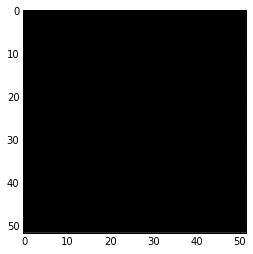

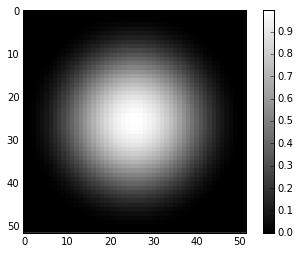

In [22]:
im = np.ones([52,52])
# a blank image
plt.imshow(im,interpolation='None',cmap='gray')
plt.show()
# putting a circular mask on the image
plt.imshow(circle_mask(im),interpolation='None',cmap='gray')
plt.colorbar()
plt.show()

First, I chose two sample volumes with 5mm resolution in both head and body coil to test with.

In [9]:
# get some test data
# head coil
head_iso_5mm = data_dict['5mm']['head']['iso'][0]
head_5deg_LR_5mm = data_dict['5mm']['head']['LR']['5deg'][0]
head_5deg_AP_5mm = data_dict['5mm']['head']['AP']['5deg'][0]
# body coil
body_iso_5mm = data_dict['5mm']['body']['iso'][0]
body_5deg_LR_5mm = data_dict['5mm']['body']['LR']['5deg'][0]
body_5deg_AP_5mm = data_dict['5mm']['body']['AP']['5deg'][0]

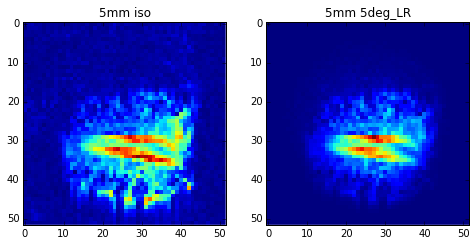

In [10]:
# Visualize the smoothed circular mask on pineapple
plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.imshow(head_iso_5mm[26,:,:], interpolation= 'None')
plt.title('5mm iso')
plt.subplot(1,2,2)
plt.imshow(circle_mask(head_iso_5mm[26,:,:]), interpolation= 'None')
plt.title('5mm 5deg_LR')
plt.show()

In [43]:
# Bessel Interpolation on the original grids and unsmoothed mask
def circle_mask(image_org):
    image = image_org.copy()
    ox = image.shape[1]/2.-0.5
    oy = image.shape[0]/2.-0.5
    r = image.shape[0]/2.-0.5
    y, x = np.ogrid[-ox:image.shape[0]-ox, -oy:image.shape[0]-oy]
    mask = x*x + y*y <= r*r
    image[~mask] = 0
    return image

def bessel_rotate(image_org, theta, mask = False, r = 10):
    image = image_org.copy()
    if(mask):
        image = circle_mask(image)

    Ib = np.zeros(image.shape)
    theta = to_radian(theta)
    s = (image.shape[0]-1)/2.

    x = np.linspace(-s, s, image.shape[1])
    y = np.linspace(-s, s, image.shape[0])
    
    xx, yy = np.meshgrid(x,y)
    
    rM = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])

    for i in np.arange(-s,s+1):
        for j in np.arange(-s,s+1):
            x = np.dot(rM, np.array([i,j]))

            if(np.sum(abs(x)>s)):
                Ib[i+s,j+s]=0
                
            else:
                R = np.sqrt((xx-x[1])**2 + (yy-x[0])**2)
                mask_R = (R == 0)
                mask_R_le = (R <= r) & (R > 0)
                Bess = np.zeros(R.shape)
                Bess[mask_R_le] = scipy.special.j1(np.pi*R[mask_R_le])/(np.pi*R[mask_R_le])
                Bess[mask_R] = 0.5
                tmp = image*Bess
                Ib[i+s,j+s] = np.sum(tmp)*np.pi/2
    return Ib

def bessel_cost_func(vol1_org, vol2_org, thetas, axis, mask=False):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    cf: cost function
    arg: string for plot titles
    '''
    t0 = time.time()
    vol1 = vol1_org.copy()
    vol2 = vol2_org.copy()
    cost_func = np.zeros([len(thetas),])
    for idx, t in enumerate(thetas):
        print t,
        new_vol2 = np.ones(vol2.shape)
        for i in xrange(len(vol2)):
            if(axis == 0):
                new_vol2[i,:,:] = bessel_rotate(vol2[i,:,:], t, mask)
                if(mask):
                    vol1[i,:,:] = circle_mask(vol1[i,:,:])
            elif(axis == 1):
                new_vol2[:,i,:] = bessel_rotate(vol2[:,i,:], t, mask)
                if(mask):
                    vol1[:,i,:] = circle_mask(vol1[:,i,:])
            else:
                new_vol2[:,:,i] = bessel_rotate(vol2[:,:,i], t, mask)
                if(mask):
                    vol1[:,:,i] = circle_mask(vol1[:,:,i])
        cost_func[idx] = cf_ssd(new_vol2,vol1)
    print time.time()-t0
    return cost_func

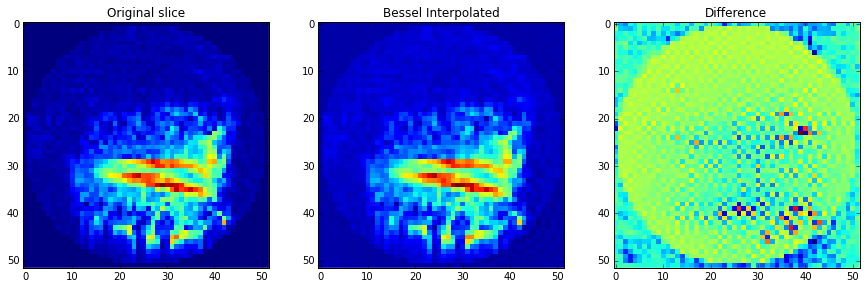

In [12]:
# Visualize Bessel Interpolation
interped = bessel_rotate(circle_mask(head_iso_5mm[26,:,:]),0)
plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
plt.imshow(circle_mask(head_iso_5mm[26,:,:]), interpolation='None')
plt.title('Original slice')
plt.subplot(1,3,2)
plt.imshow(interped, interpolation='None')
plt.title('Bessel Interpolated')
plt.subplot(1,3,3)
plt.imshow(interped-head_iso_5mm[26,:,:], interpolation='None')
plt.title('Difference')
plt.show()

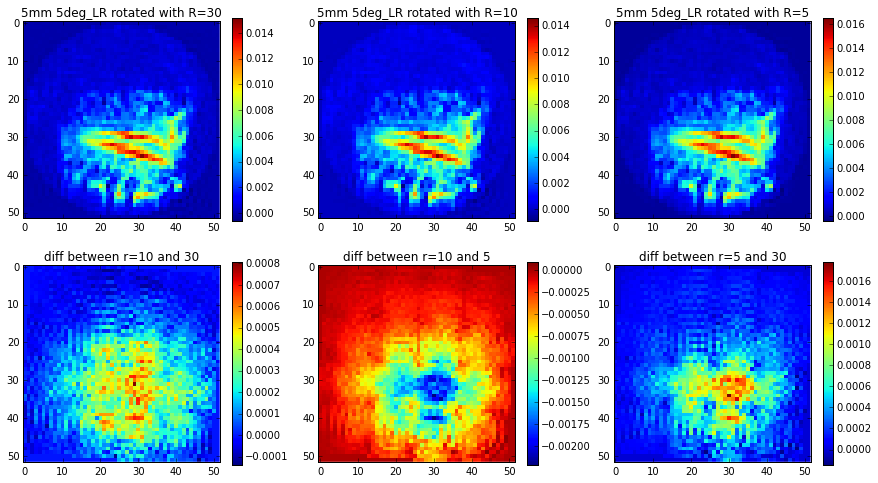

In [46]:
result_30 = bessel_rotate(head_iso_5mm[26,:,:],5,mask=True,r=30)
result_10 = bessel_rotate(head_iso_5mm[26,:,:],5,mask=True,r=10)
result_5 = bessel_rotate(head_iso_5mm[26,:,:],5,mask=True,r=5)
plt.figure(figsize=[15,8])
plt.subplot(2,3,1)
plt.imshow(result_30, interpolation= 'None')
plt.title('5mm 5deg_LR rotated with R=30')
plt.colorbar()
plt.subplot(2,3,2)
plt.imshow(result_10, interpolation= 'None')
plt.title('5mm 5deg_LR rotated with R=10')
plt.colorbar()
plt.subplot(2,3,3)
plt.imshow(result_5, interpolation= 'None')
plt.title('5mm 5deg_LR rotated with R=5')
plt.colorbar()
plt.subplot(2,3,4)
plt.imshow(result_30-result_10, interpolation= 'None')
plt.title('diff between r=10 and 30')
plt.colorbar()
plt.subplot(2,3,5)
plt.imshow(result_10-result_5, interpolation= 'None')
plt.title('diff between r=10 and 5')
plt.colorbar()
plt.subplot(2,3,6)
plt.imshow(result_5-result_30, interpolation= 'None')
plt.title('diff between r=5 and 30')
plt.colorbar()
plt.show()

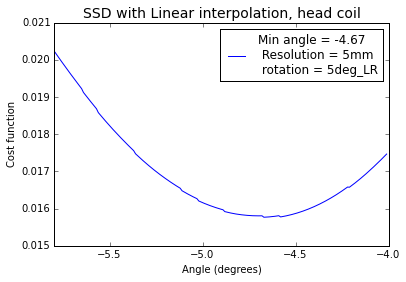

In [13]:
# Linear Interpolation for reference
thetas = np.arange(-5.8,-4.0,0.01)
cost = rot_cost_func(head_iso_5mm,head_5deg_LR_5mm,thetas,axis=0)
plot_cost_func(thetas, cost, '5mm', 'Linear','5deg_LR', 'head')

4.5 4.6 4.7 4.8 4.9 5.0 5.1 5.2 122.167024851


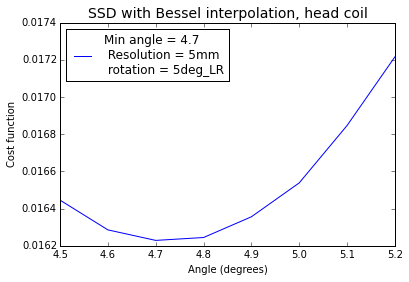

In [14]:
# head coil Bessel interpolation with R=10
thetas = np.arange(4.5,5.2,0.1)
cost_5deg_LR = bessel_cost_func(head_iso_5mm, head_5deg_LR_5mm, thetas, axis=0, mask=True)
plot_cost_func(thetas, cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'head')

-5.5 -5.4 -5.3 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 154.962107897


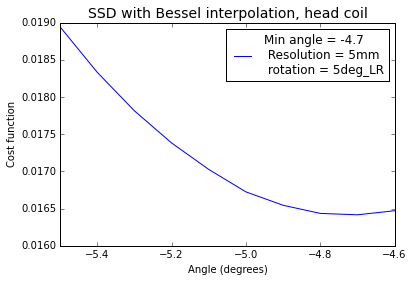

In [15]:
# head coil Bessel interpolation with R=10 reversed
thetas = np.arange(-5.5,-4.5,0.1)
cost_5deg_LR = bessel_cost_func(head_5deg_LR_5mm, head_iso_5mm, thetas, axis=0,mask=True)
plot_cost_func(thetas, cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'head')

4.5 4.6 4.7 4.8 4.9 5.0 5.1 5.2 125.22858882


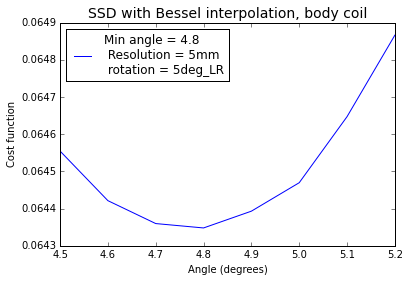

In [45]:
# body coil Bessel interpolation with R=10
thetas = np.arange(4.5,5.3,0.1)
cost_5deg_LR = bessel_cost_func(body_iso_5mm, body_5deg_LR_5mm, thetas, axis=0, mask = True)
plot_cost_func(thetas, cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'body')

In [16]:
# Bessel Interpolation with Hanning window
def bessel_rotate(image, theta, mask = True, r = 10):

    Ib = np.zeros(image.shape)
    theta = to_radian(theta)
    s = (image.shape[0]-1)/2.

    x = np.linspace(-s, s, image.shape[1])
    y = np.linspace(-s, s, image.shape[0])
    
    xx, yy = np.meshgrid(x,y)
    
    rM = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    for i in np.arange(-s,s+1):
        for j in np.arange(-s,s+1):
            x = np.dot(rM, np.array([i,j]))

            if(np.sum(abs(x)>s)):
                Ib[i+s,j+s]=0
                
            else:
                R = np.sqrt((xx-x[1])**2 + (yy-x[0])**2)
                mask_R = (R == 0)
                Bess = np.zeros(R.shape)
                Bess[~mask_R] = scipy.special.j1(np.pi*R[~mask_R])*hann(R[~mask_R],image.shape[0])/(np.pi*R[~mask_R])
                Bess[mask_R] = 0.5
                tmp = image*Bess
                Ib[i+s,j+s] = np.sum(tmp)*np.pi/2
    return Ib

4.5 4.6 4.7 4.8 4.9 5.0 5.1 5.2 384.536113024


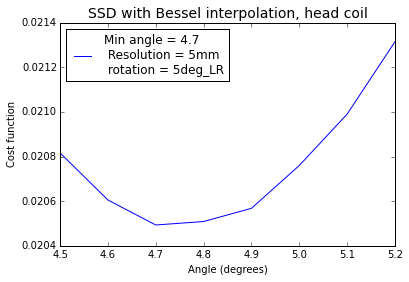

In [17]:
# head coil Bessel interpolation using hanning window with unsmoothed mask
thetas = np.arange(4.5,5.2,0.1)
cost_5deg_LR = bessel_cost_func(head_iso_5mm, head_5deg_LR_5mm, thetas, axis=0, mask = True)
plot_cost_func(thetas, cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'head')

-5.5 -5.4 -5.3 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 488.757484913


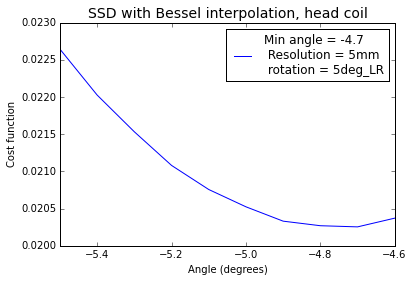

In [18]:
# head coil Bessel interpolation reversed
thetas = np.arange(-5.2,-4.5,0.1)
cost_5deg_LR = bessel_cost_func(head_5deg_LR_5mm, head_iso_5mm, thetas, axis=0,mask=True)
plot_cost_func(thetas, cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'head')

In [41]:
# Try smoothed Mask
def hann(n, N):
    n = abs(n - (N-1.)/2.)
    return 0.5*(1-np.cos(2*np.pi*n/(N-1)))

def circle_mask(image_org):
    image = image_org.copy()
    ox = image.shape[1]/2.-0.5
    oy = image.shape[0]/2.-0.5
    r = image.shape[0]/2.-0.5
    y, x = np.ogrid[-ox:image.shape[0]-ox, -oy:image.shape[0]-oy]
    rad = np.sqrt(x*x + y*y)
    mask = x*x + y*y < r*r
    image[~mask] = 0
    image[mask] = image[mask]*hann(rad[mask], image.shape[0])
    return image

4.5 4.6 4.7 4.8 4.9 5.0 5.1 5.2 393.32140708


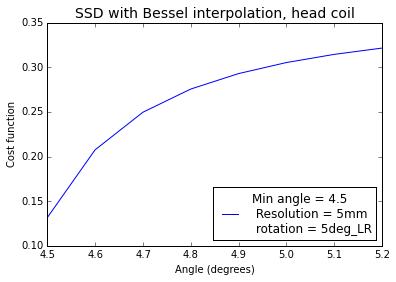

In [42]:
# head coil Bessel interpolation using hanning window with smoothed mask
res = ''
deg = ''
rot = 'LR'
thetas = np.arange(4.5,5.2,0.1)
cost_5deg_LR = bessel_cost_func(head_iso_5mm, head_5deg_LR_5mm, thetas, axis=0, mask = True)
plot_cost_func(thetas, cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'head')

In [72]:
# Bessel Interpolation with Halton Sampling using unsmoothed mask
def circle_mask(image_org):
    image = image_org.copy()
    ox = image.shape[1]/2.-0.5
    oy = image.shape[0]/2.-0.5
    r = image.shape[0]/2.-0.5
    y, x = np.ogrid[-ox:image.shape[0]-ox, -oy:image.shape[0]-oy]
    mask = x*x + y*y <= r*r
    image[~mask] = 0
    return image

def bessel_rotate_halton(image, theta, x1, y1):
    Ib = []
    theta = to_radian(theta)
    s = (image.shape[0]-1)/2.
    
    rM = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    x = []
    for i in np.arange(-s,s+1):
        for j in np.arange(-s,s+1):
            x.append(np.dot(rM, np.array([i,j])))
    x = np.array(x)
    for idx in xrange(len(x1)):
        R = np.sqrt((x[:,1]-x1[idx])**2 + (x[:,0]-y1[idx])**2)
        mask_R = (R == 0)
        Bess = np.zeros(R.shape)
        Bess[~mask_R] = scipy.special.j1(np.pi*R[~mask_R])*hann(R[~mask_R],image.shape[0])/(np.pi*R[~mask_R])
        #Bess[~mask_R] = scipy.special.j1(np.pi*R[~mask_R])/(np.pi*R[~mask_R])
        Bess[mask_R] = 0.5
        #Bess = Bess/(2*np.pi*np.sum(Bess*R))
        tmp = image.ravel()*Bess
        Ib.append(np.sum(tmp)*np.pi/2)
    return np.array(Ib)

def bessel_halton_cost_func(vol1_org, vol2, N, thetas, axis):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    cf: cost function
    arg: string for plot titles
    '''
    vol1 = vol1_org.copy()
    # initialize vector to store cost
    cost_func = np.zeros([len(thetas),])
    # generate Halton sample points
    s = (len(vol1)-1)/2.
    sequencer = ghalton.GeneralizedHalton(ghalton.EA_PERMS[:3])
    sequencer.reset()
    points = sequencer.get(N)
    pts = np.array(points)
    x1 = (len(vol1)-1) * pts[:,0] - s
    y1 = (len(vol1)-1) * pts[:,1] - s
    new_vol1 = np.empty([len(vol1),N])
    for i in xrange(len(vol1)):
        if(axis == 0):
            sub1 = circle_mask(vol1[i,:,:])
        elif(axis == 1):
            sub1 = circle_mask(vol1[:,i,:])
        else:
            sub1 = circle_mask(vol1[:,:,i])
        rot = bessel_rotate_halton(sub1, 0, x1, y1)
        new_vol1[i] = rot
    for idx, t in enumerate(thetas):
        print t, 
        new_vol2 = np.empty([len(vol2),N])
        for i in xrange(len(vol2)):
            if(axis==0):
                sub2 = circle_mask(vol2[i,:,:])
            elif(axis==1):
                sub2 = circle_mask(vol2[:,i,:])
            else:
                sub2 = circle_mask(vol2[:,:,i])
            new_vol2[i] = bessel_rotate_halton(sub2, t, x1, y1)
        cost_func[idx] = cf_ssd(new_vol2,new_vol1)
    return cost_func

def bessel_halton_cost_func_circle(vol1, vol2, N, thetas, axis):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    cf: cost function
    arg: string for plot titles
    '''
    cost_func = np.zeros([len(thetas),])
    # generate Halton sample points
    s = (len(vol1)-1)/2.
    sequencer = ghalton.GeneralizedHalton(ghalton.EA_PERMS[:3])
    sequencer.reset()
    points = sequencer.get(N)
    pts = np.array(points)
    xx1 = (len(vol1)-1) * pts[:,0] - s
    yy1 = (len(vol1)-1) * pts[:,1] - s
    mask = np.sqrt(xx1**2+yy1**2) < s - 1
    x1 = xx1[mask]
    y1 = yy1[mask]
    new_vol1 = np.zeros([len(vol1),len(x1)])
    print len(x1),
    for i in xrange(len(vol1)):
        if(axis == 0):
            sub1 = circle_mask(vol1[i,:,:])
        elif(axis == 1):
            sub1 = circle_mask(vol1[:,i,:])
        else:
            sub1 = circle_mask(vol1[:,:,i])
        rot = bessel_rotate_halton(sub1, 0, x1, y1)
        new_vol1[i] = rot
    for idx, t in enumerate(thetas):
        print t, 
        new_vol2 = np.empty([len(vol2),len(x1)])
        for i in xrange(len(vol2)):
            if(axis==0):
                sub2 = circle_mask(vol2[i,:,:])
            elif(axis==1):
                sub2 = circle_mask(vol2[:,i,:])
            else:
                sub2 = circle_mask(vol2[:,:,i])
            rot = bessel_rotate_halton(sub2, t, x1, y1)
            new_vol2[i] = rot
        cost_func[idx] = cf_ssd(new_vol2,new_vol1)
    return cost_func

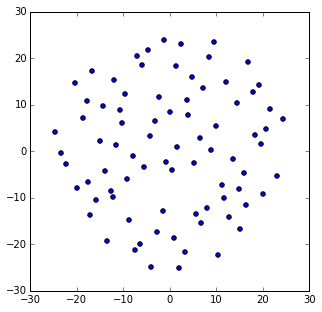

In [62]:
N = 100
sequencer = ghalton.GeneralizedHalton(ghalton.EA_PERMS[:3])
sequencer.reset()
points = sequencer.get(N)
pts = np.array(points)
s = (len(head_iso_5mm)-1)/2.
x1 = (len(head_iso_5mm)-1) * pts[:,0] - s
y1 = (len(head_iso_5mm)-1) * pts[:,1] - s

mask = np.sqrt(x1**2+y1**2) < s
plt.figure(figsize=[5,5])
plt.scatter(x1[mask],y1[mask])
plt.show()

73 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

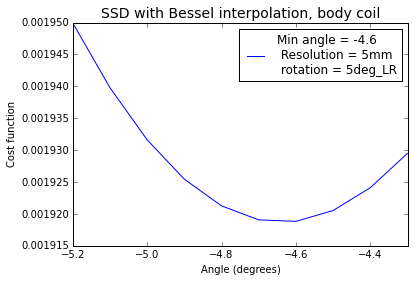

 36 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

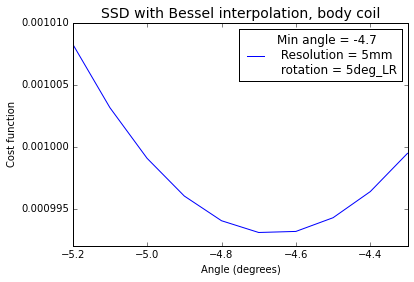

 29 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

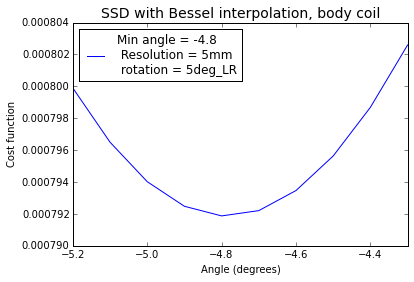

 23 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

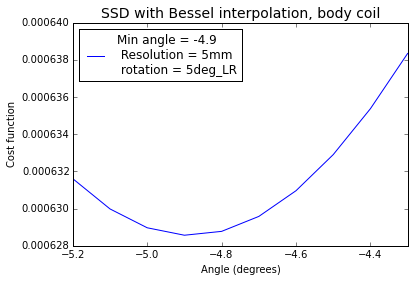

 15 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

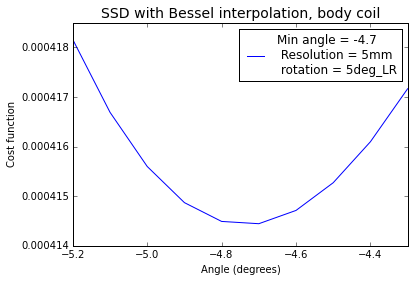

 9 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

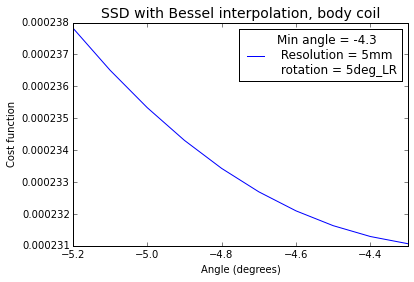

In [65]:
# Bessel Interpolation with Halton Sampling, unsmoothed mask, body coil, using hann window
thetas = np.arange(-5.2,-4.3,0.1)
N_ls = [100,50,40,30,20,10]
res = '5mm'
coil = 'body'
rot = 'LR'
deg = '5deg'
for N in N_ls:
    halton_cost_5deg_LR = bessel_halton_cost_func_circle(data_dict[res][coil]['iso'][0],
                                                         data_dict[res][coil][rot][deg][0], N, thetas, axis=0)
    plot_cost_func(thetas, halton_cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'body')
    plt.show()

73 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

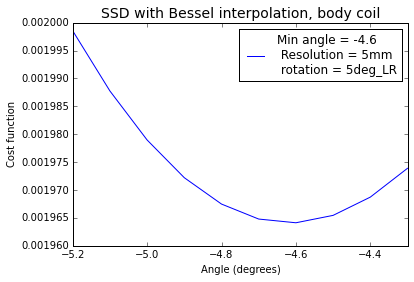

 36 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

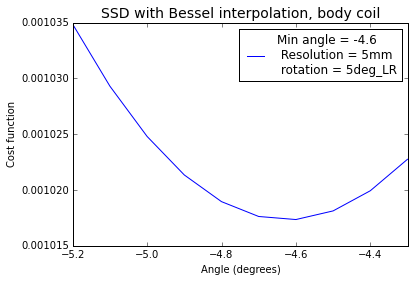

 29 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

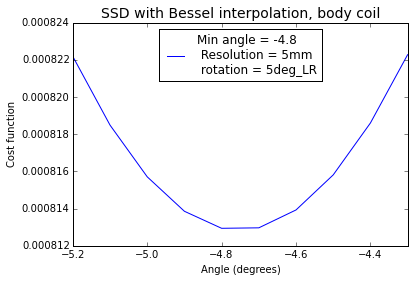

 23 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

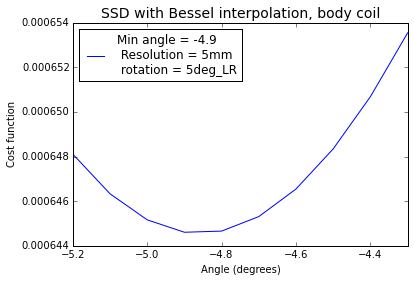

 15 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

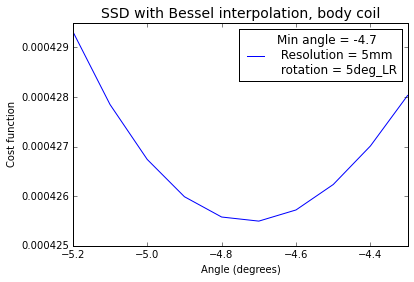

 9 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

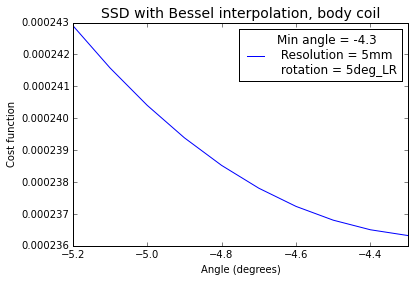

In [70]:
# Bessel Interpolation with Halton Sampling, unsmoothed mask, body coil, no hann window in bessel interpolation
thetas = np.arange(-5.2,-4.3,0.1)
N_ls = [100,50,40,30,20,10]
res = '5mm'
coil = 'body'
rot = 'LR'
deg = '5deg'
for N in N_ls:
    halton_cost_5deg_LR = bessel_halton_cost_func_circle(data_dict[res][coil]['iso'][0],
                                                         data_dict[res][coil][rot][deg][0], N, thetas, axis=0)
    plot_cost_func(thetas, halton_cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'body')
    plt.show()

73 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

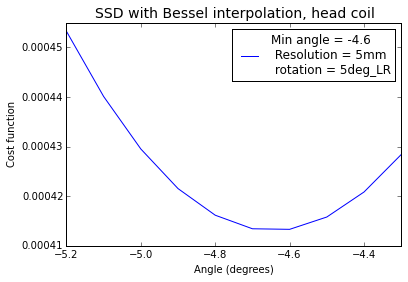

 36 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

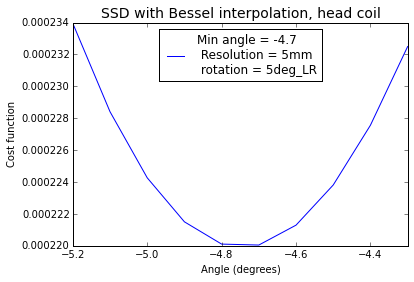

 29 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

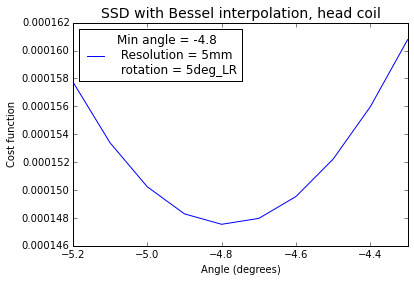

 23 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

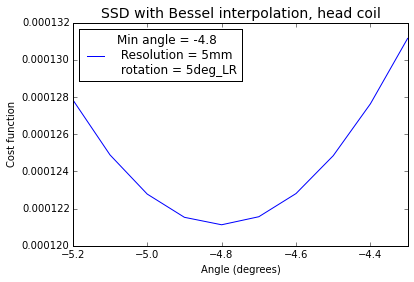

 15 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

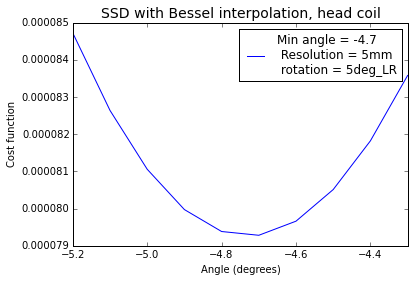

 9 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

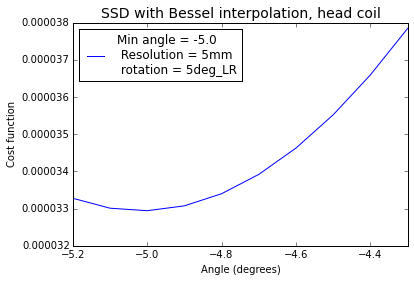

In [68]:
# Bessel Interpolation with Halton Sampling, unsmoothed mask, head coil, using hann window in bessel interpolation
thetas = np.arange(-5.2,-4.3,0.1)
N_ls = [100,50,40,30,20,10]
res = '5mm'
coil = 'head'
rot = 'LR'
deg = '5deg'
for N in N_ls:
    halton_cost_5deg_LR = bessel_halton_cost_func_circle(data_dict[res][coil]['iso'][0],
                                                         data_dict[res][coil][rot][deg][0], N, thetas, axis=0)
    plot_cost_func(thetas, halton_cost_5deg_LR, res, 'Bessel',deg+'_'+rot, coil)
    plt.show()

73 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

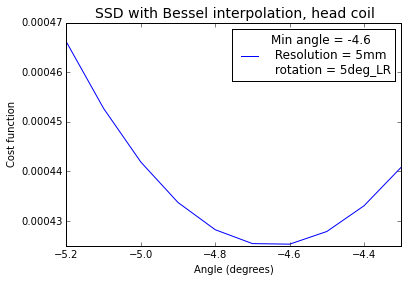

 36 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

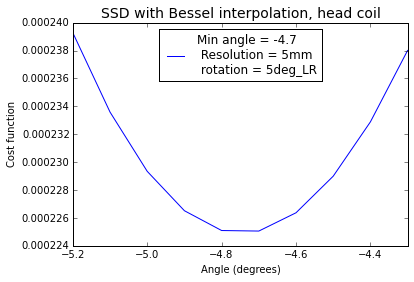

 29 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

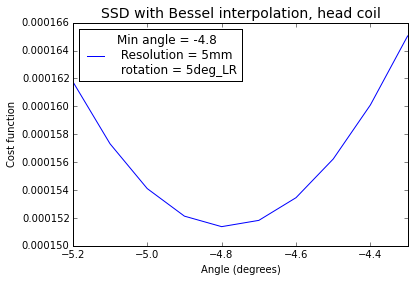

 23 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

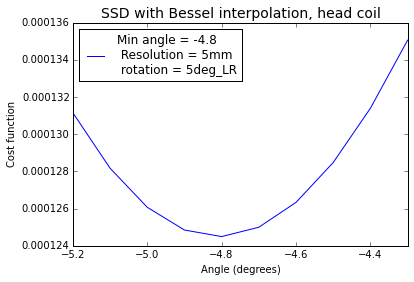

 15 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

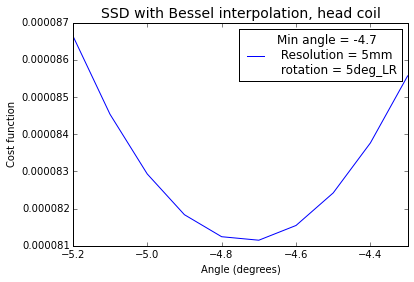

 9 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

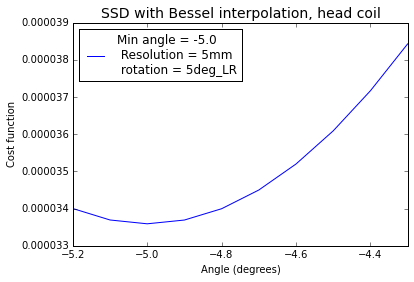

In [71]:
# Bessel Interpolation with Halton Sampling, unsmoothed mask, head coil, no hann windown in bessel interpolation
thetas = np.arange(-5.2,-4.3,0.1)
N_ls = [100,50,40,30,20,10]
res = '5mm'
coil = 'head'
rot = 'LR'
deg = '5deg'
for N in N_ls:
    halton_cost_5deg_LR = bessel_halton_cost_func_circle(data_dict[res][coil]['iso'][0],
                                                         data_dict[res][coil][rot][deg][0], N, thetas, axis=0)
    plot_cost_func(thetas, halton_cost_5deg_LR, res, 'Bessel',deg+'_'+rot, coil)
    plt.show()

In [74]:
# Smoothed Mask
def circle_mask(image_org):
    image = image_org.copy()
    ox = image.shape[1]/2.-0.5
    oy = image.shape[0]/2.-0.5
    r = image.shape[0]/2.-0.5
    y, x = np.ogrid[-ox:image.shape[0]-ox, -oy:image.shape[0]-oy]
    rad = np.sqrt(x*x + y*y)
    mask = x*x + y*y < r*r
    image[~mask] = 0
    image[mask] = image[mask]*hann(rad[mask], image.shape[0])
    return image

73 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

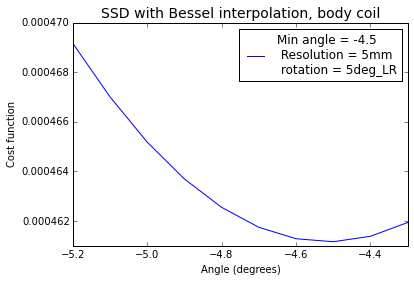

 36 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

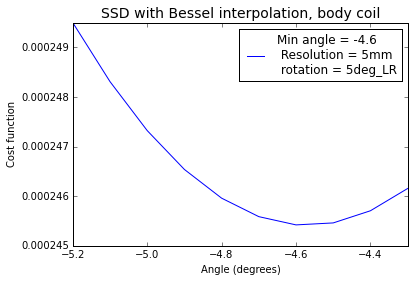

 29 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

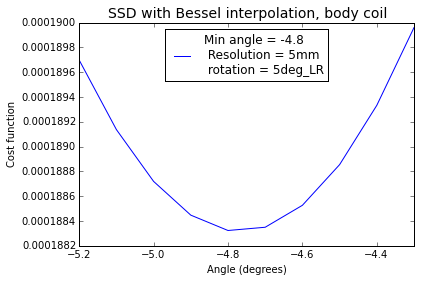

 23 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

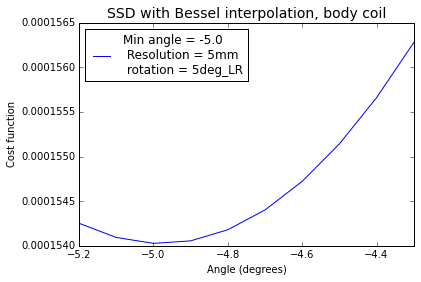

 15 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

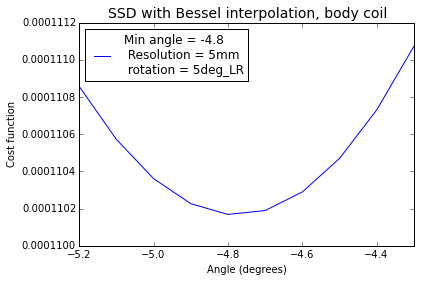

 9 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

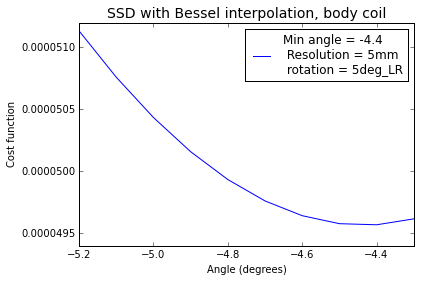

In [75]:
# Bessel Interpolation with Halton Sampling, smoothed mask, body coil
thetas = np.arange(-5.2,-4.3,0.1)
N_ls = [100,50,40,30,20,10]
res = '5mm'
coil = 'body'
rot = 'LR'
deg = '5deg'
for N in N_ls:
    halton_cost_5deg_LR = bessel_halton_cost_func_circle(data_dict[res][coil]['iso'][0],
                                                         data_dict[res][coil][rot][deg][0], N, thetas, axis=0)
    plot_cost_func(thetas, halton_cost_5deg_LR, res, 'Bessel',deg+'_'+rot, coil)
    plt.show()

73 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

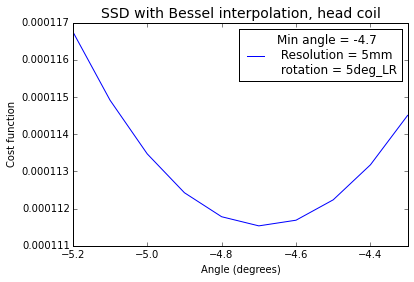

 36 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

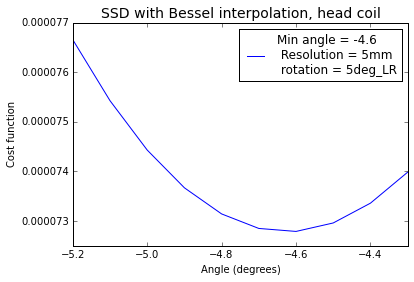

 29 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

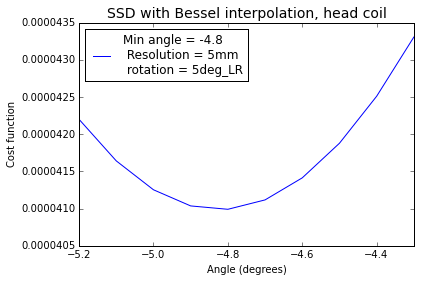

 23 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

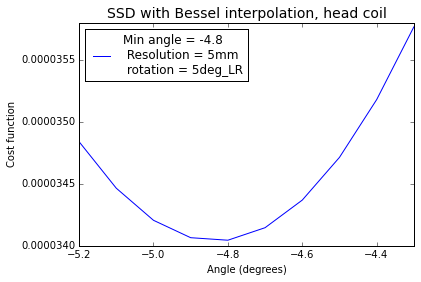

 15 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

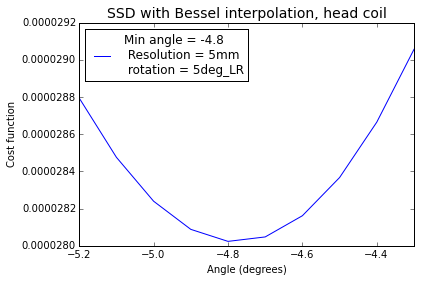

 9 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

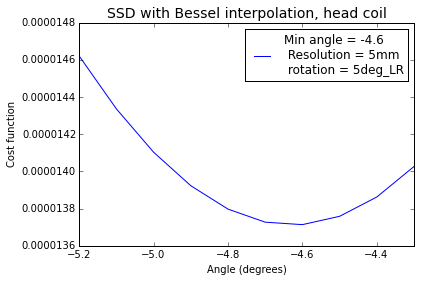

In [77]:
# Bessel Interpolation with Halton Sampling, smoothed mask, head coil
thetas = np.arange(-5.2,-4.3,0.1)
N_ls = [100,50,40,30,20,10]
res = '5mm'
coil = 'head'
rot = 'LR'
deg = '5deg'
for N in N_ls:
    halton_cost_5deg_LR = bessel_halton_cost_func_circle(data_dict[res][coil]['iso'][0],
                                                         data_dict[res][coil][rot][deg][0], N, thetas, axis=0)
    plot_cost_func(thetas, halton_cost_5deg_LR, res, 'Bessel',deg+'_'+rot, coil)
    plt.show()

723 -5.1 -5.09 -5.08 -5.07 -5.06 -5.05 -5.04 -5.03 -5.02 -5.01 -5.0 -4.99 -4.98 -4.97 -4.96 -4.95 -4.94 -4.93 -4.92 -4.91

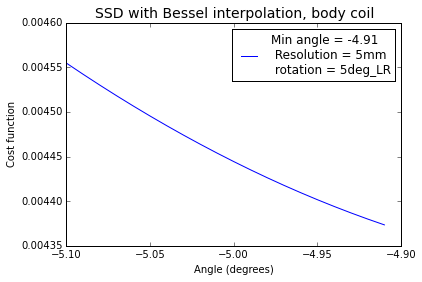

In [265]:
thetas = np.arange(-5.1,-4.9,0.01)
N = 1000
halton_cost_5deg_LR = bessel_halton_cost_func_circle(head_iso_5mm, head_5deg_LR_5mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'body')
plt.show()

In [259]:
# get some more test data
# head coil
head_iso_8mm = data_dict['8mm']['head']['iso'][0]
head_5deg_LR_8mm = data_dict['8mm']['head']['LR']['5deg'][0]
head_5deg_AP_8mm = data_dict['8mm']['head']['AP']['5deg'][0]
# body coil
body_iso_8mm = data_dict['8mm']['body']['iso'][0]
body_5deg_LR_8mm = data_dict['8mm']['body']['LR']['5deg'][0]
body_5deg_AP_8mm = data_dict['8mm']['body']['AP']['5deg'][0]

## Linear Interpolation

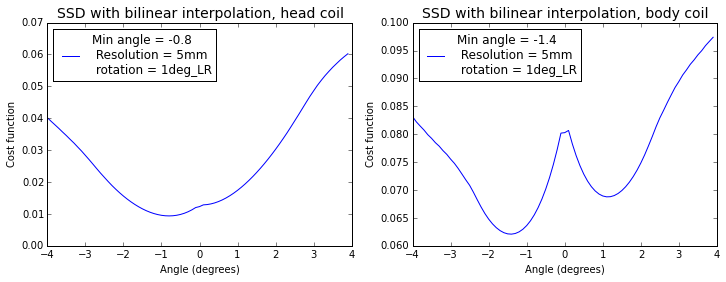

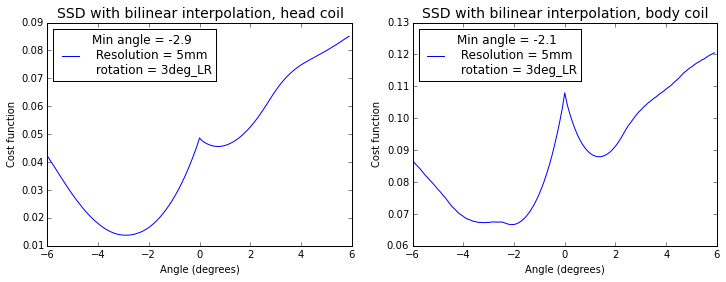

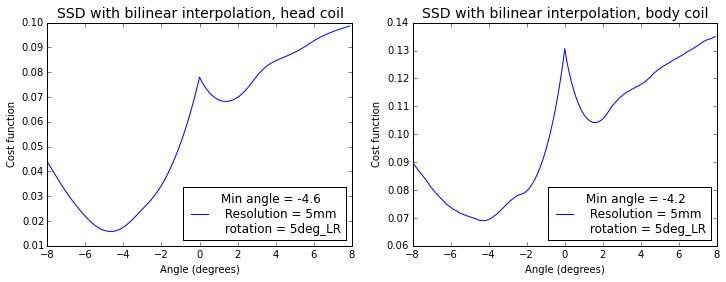

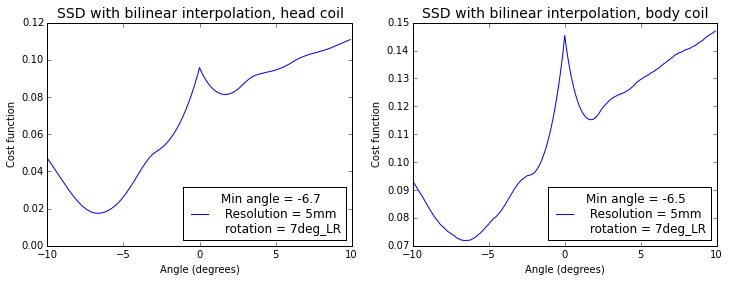

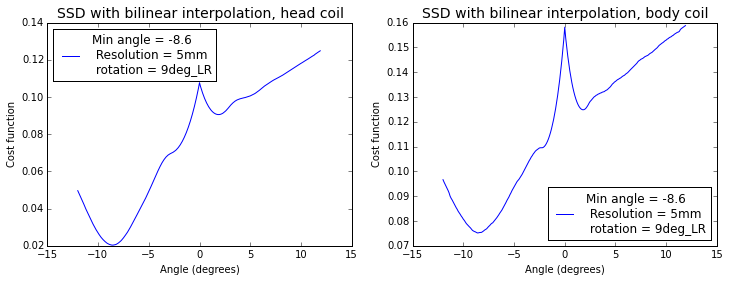

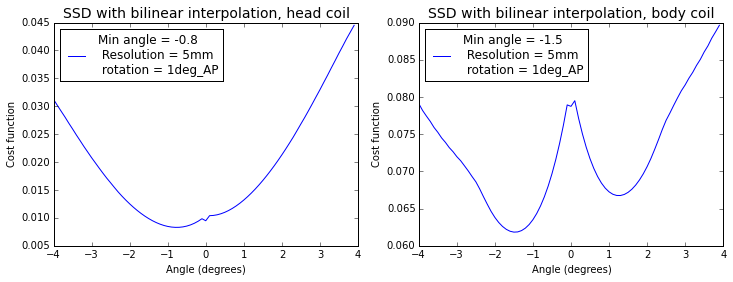

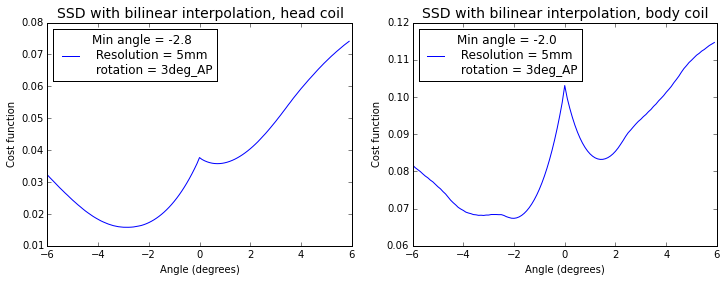

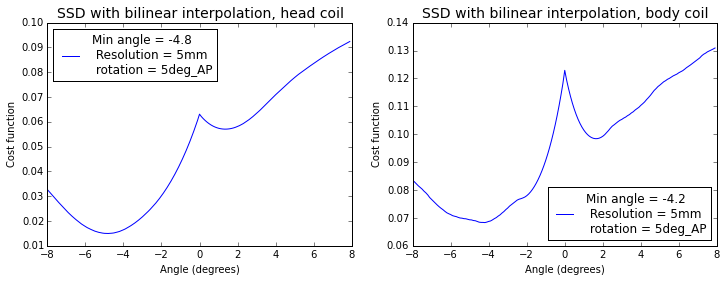

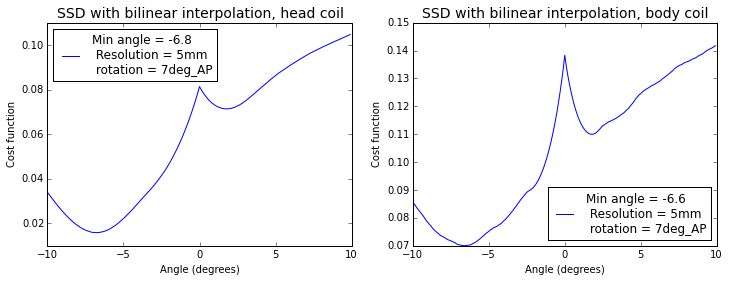

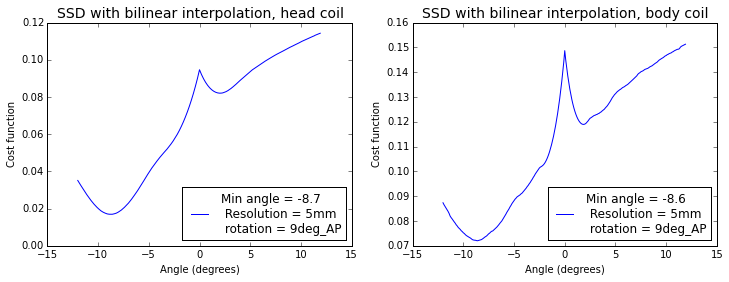

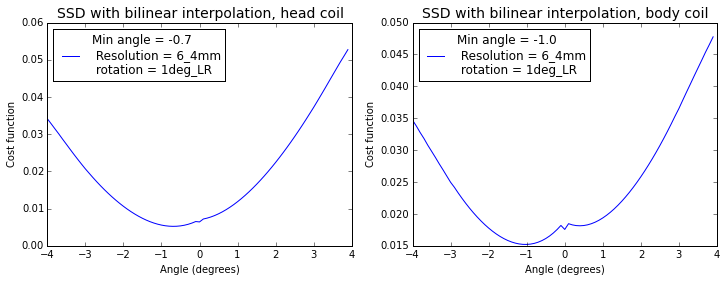

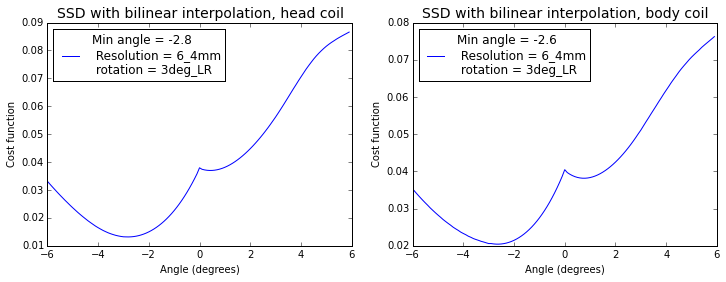

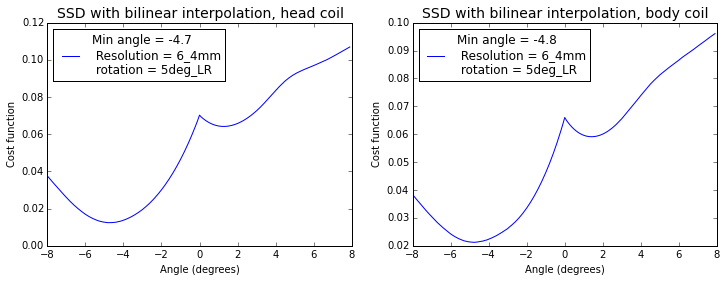

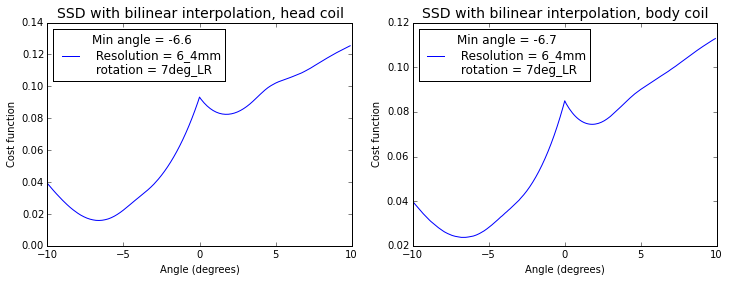

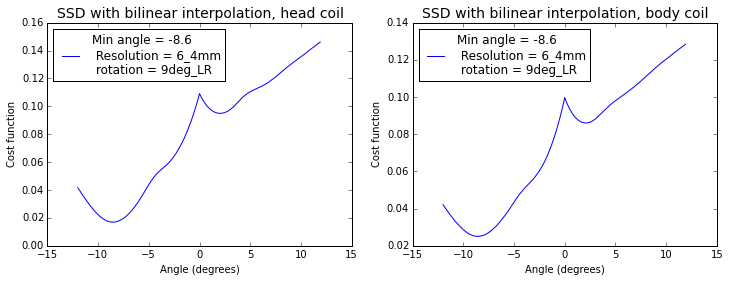

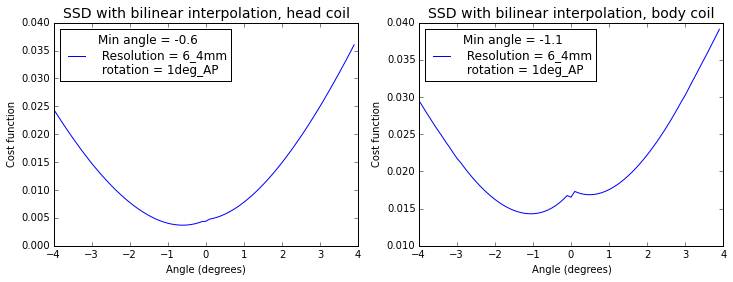

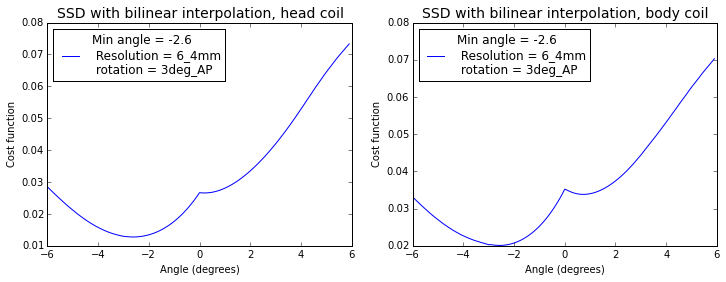

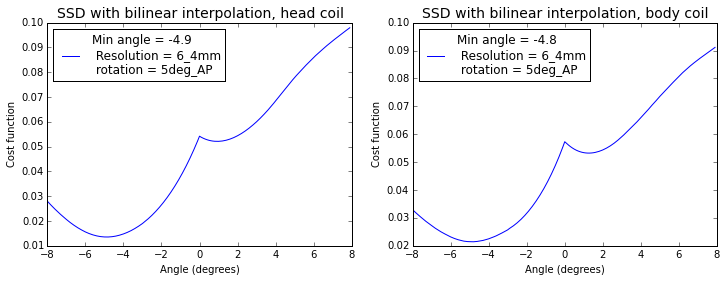

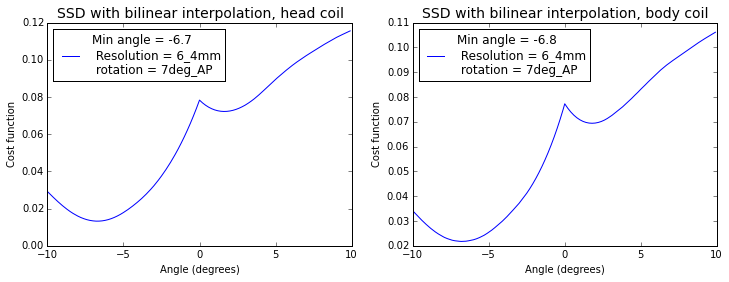

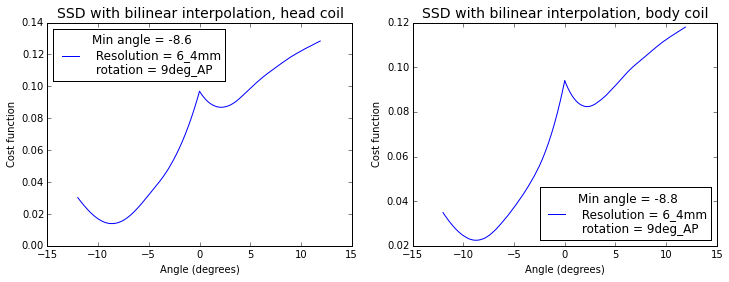

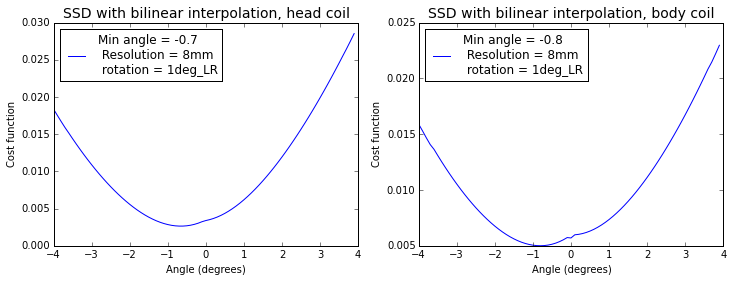

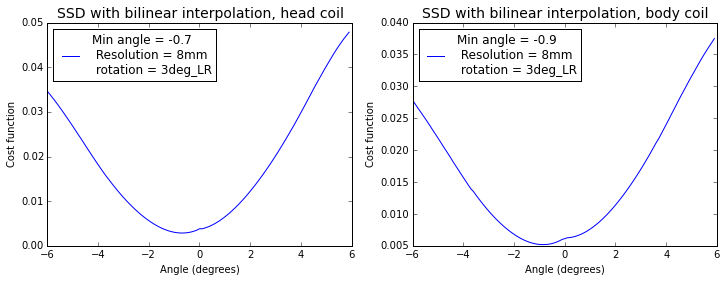

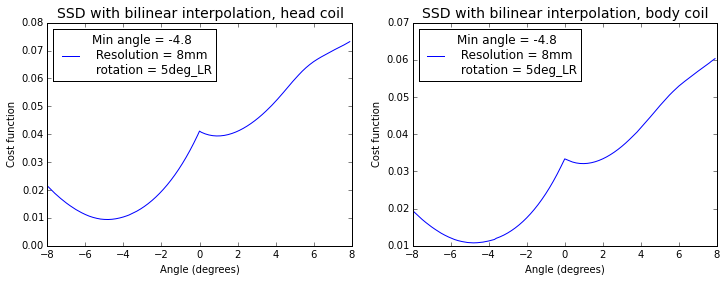

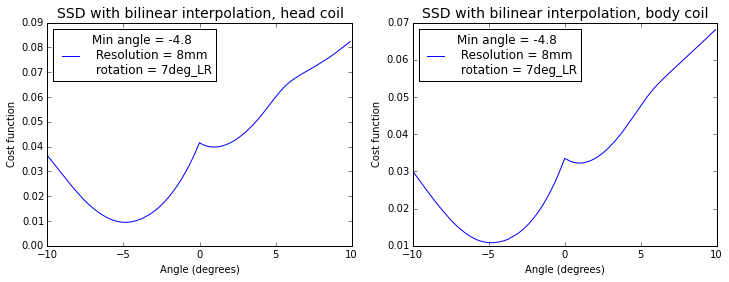

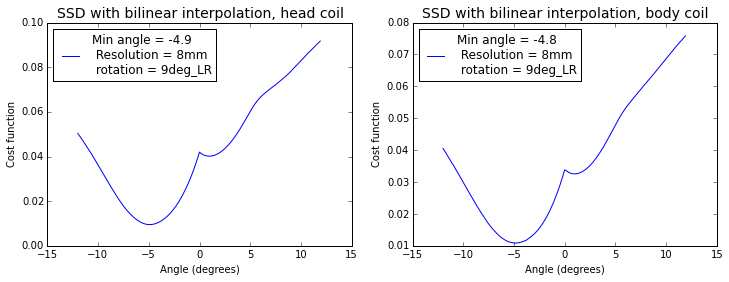

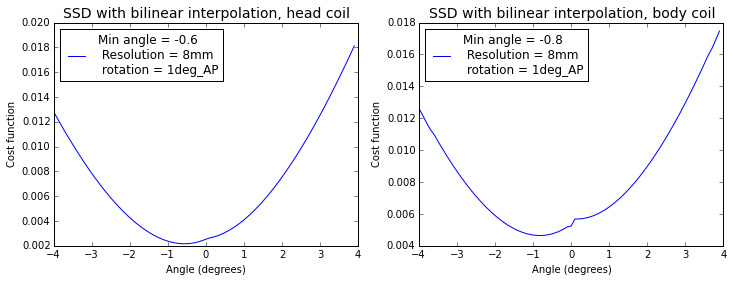

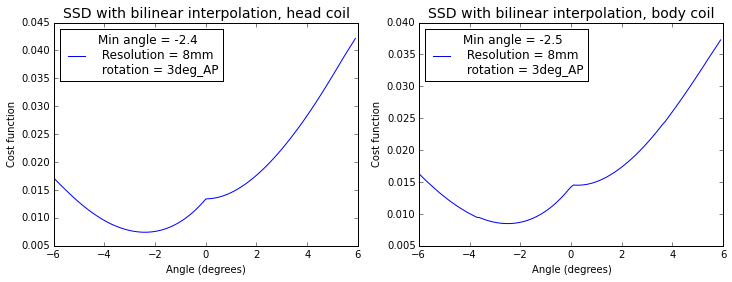

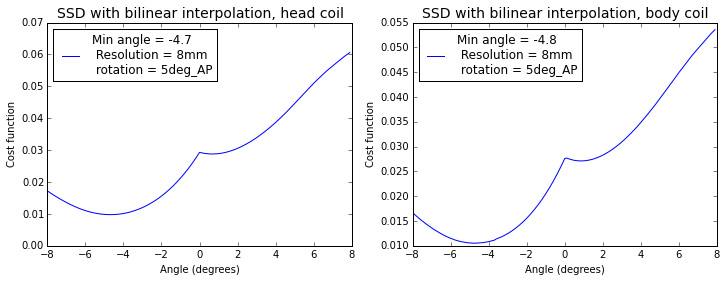

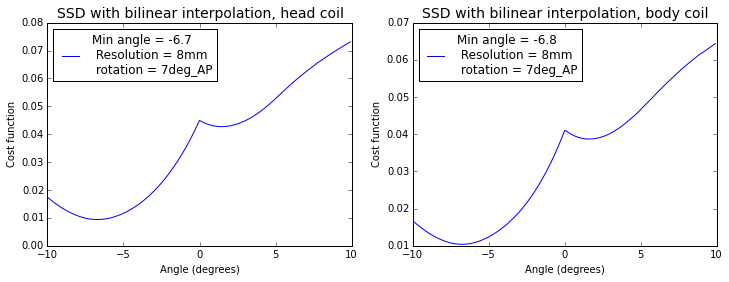

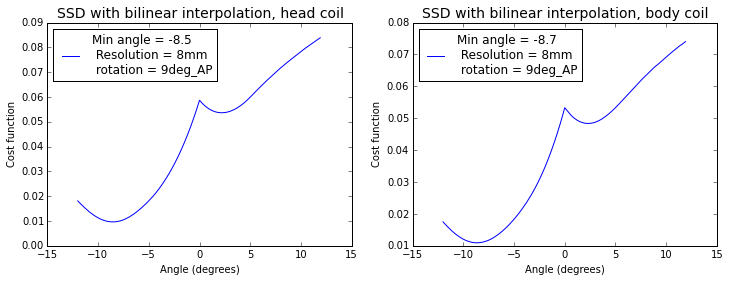

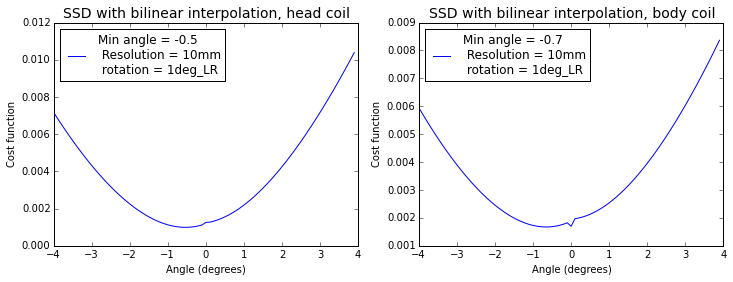

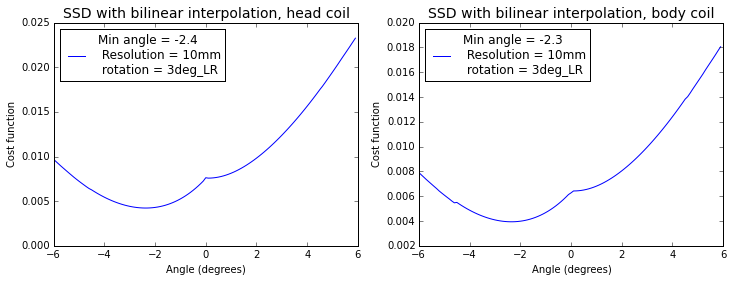

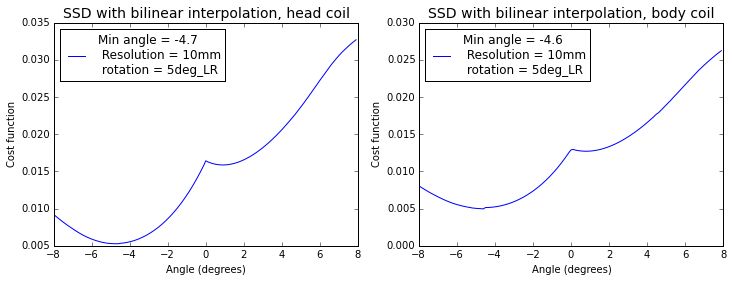

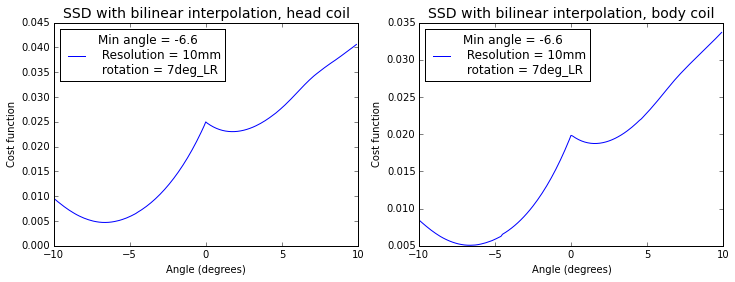

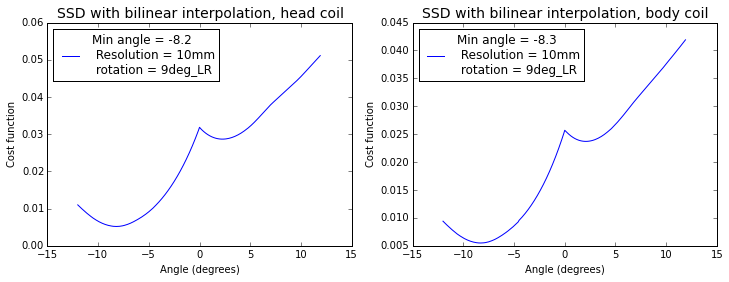

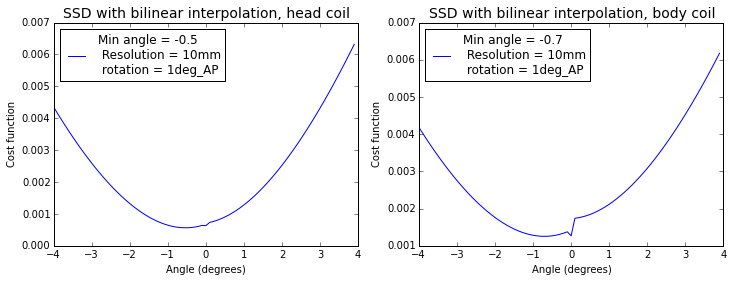

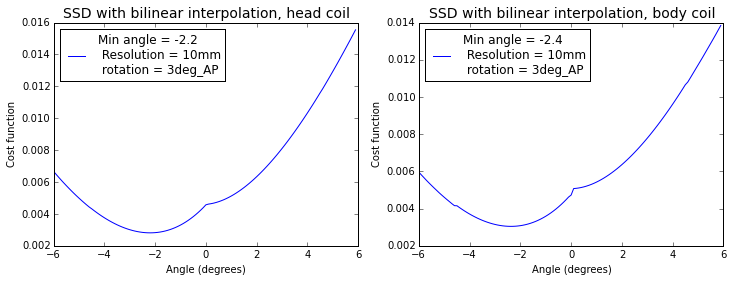

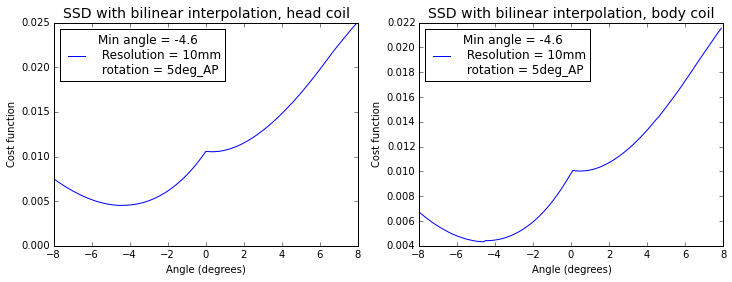

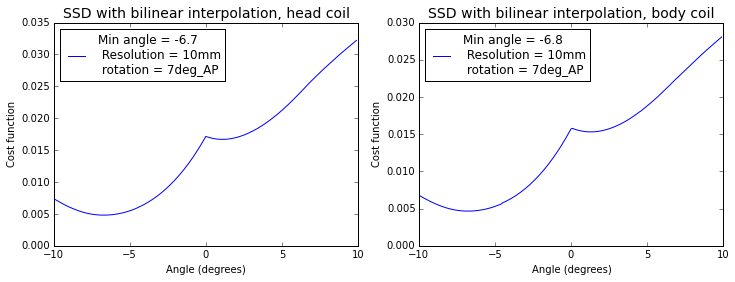

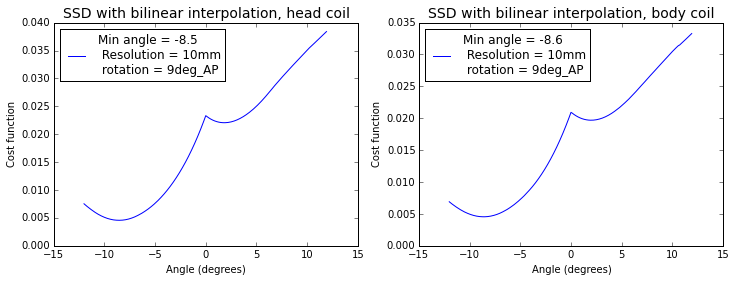

In [42]:
# repetition 0
rot_axes = ['LR','AP']
degrees = ['1deg','3deg','5deg','7deg','9deg']
resolutions = ['5mm','6_4mm','8mm','10mm']
for res in resolutions:
    for rot in rot_axes:
        if(rot == 'LR'): ax = 0
        if(rot == 'AP'): ax = 1
        for deg in degrees:
            plt.figure(figsize=[12,4])
            for idx, coil in enumerate(['head', 'body']):
                d = int(deg[0])
                thetas = np.arange(-d-3,d+3,0.1)
                cost = rot_cost_func(data_dict[res][coil]['iso'][0],data_dict[res][coil][rot][deg][0],thetas,axis=ax)
                plt.subplot(1,2,idx+1)
                plot_cost_func(thetas, cost, res, 'bilinear',deg+'_'+rot, coil)
            plt.show()

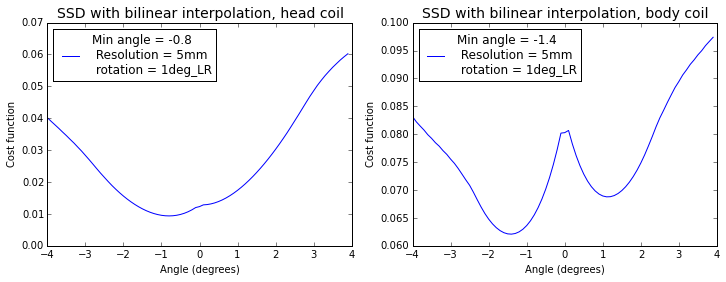

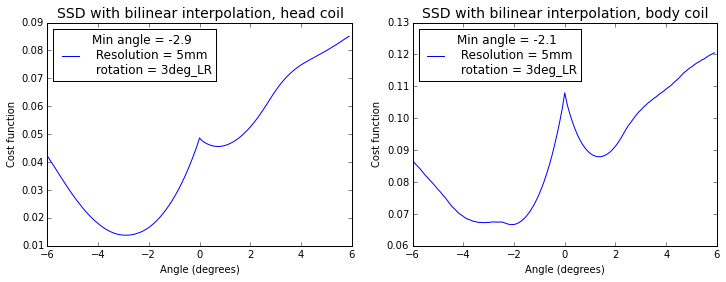

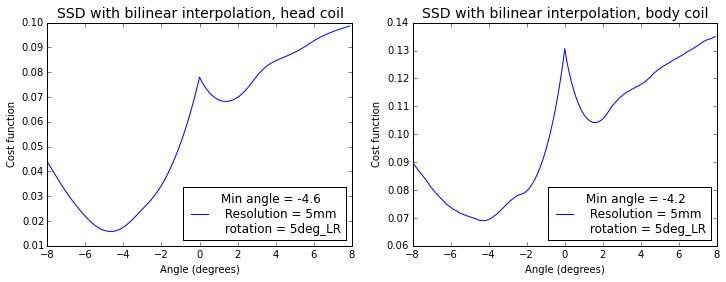

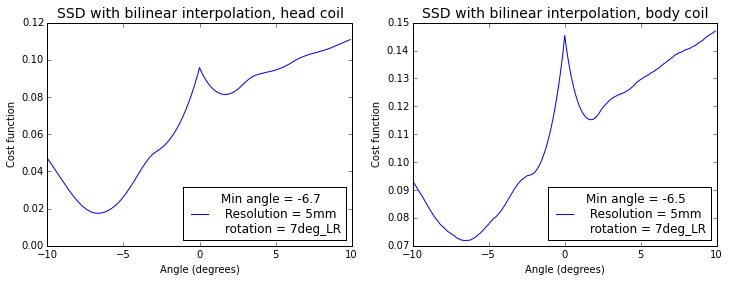

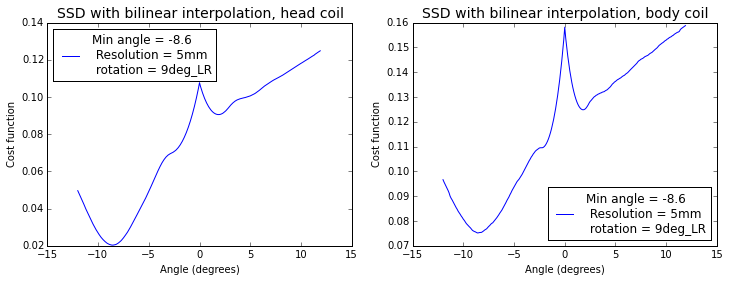

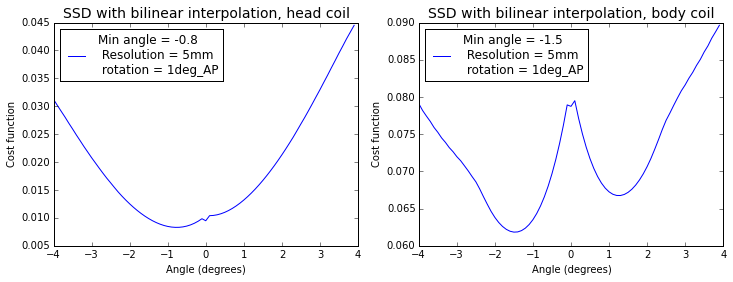

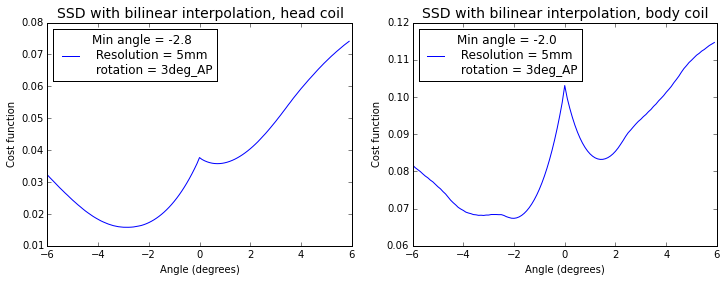

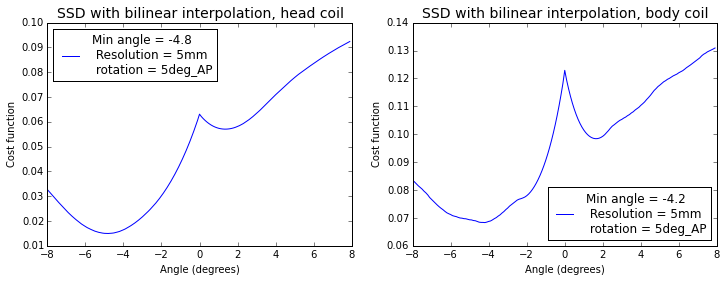

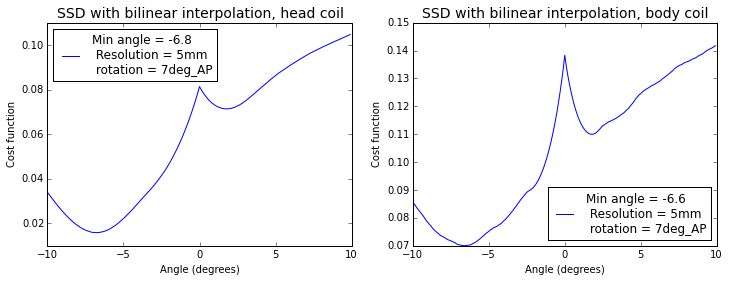

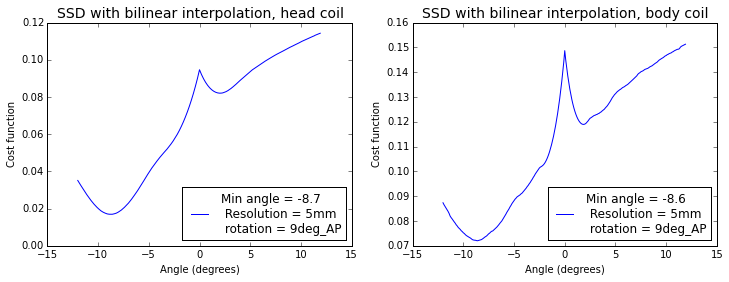

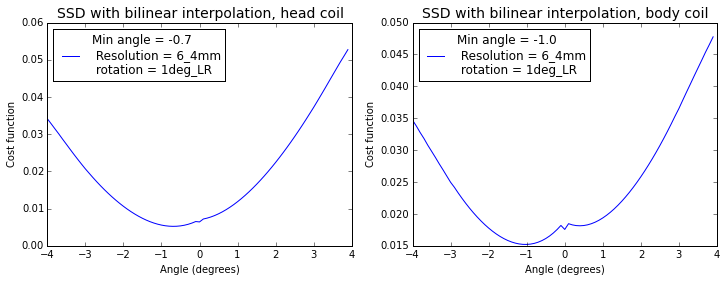

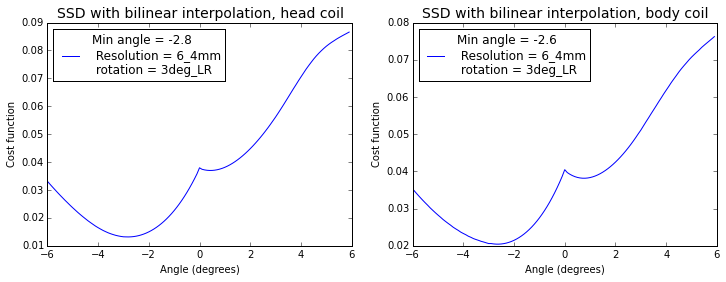

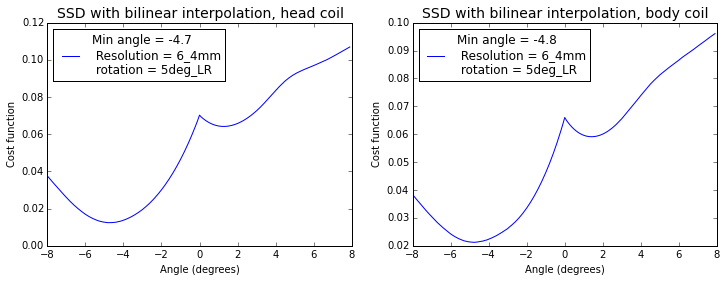

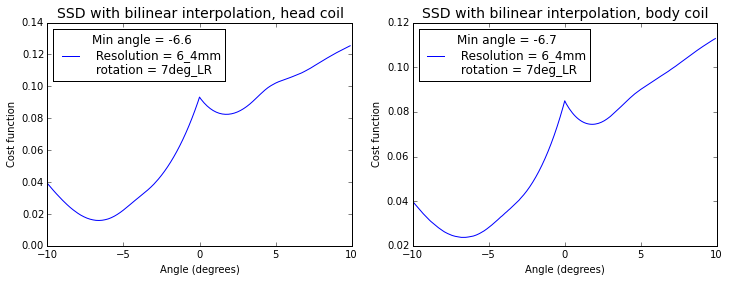

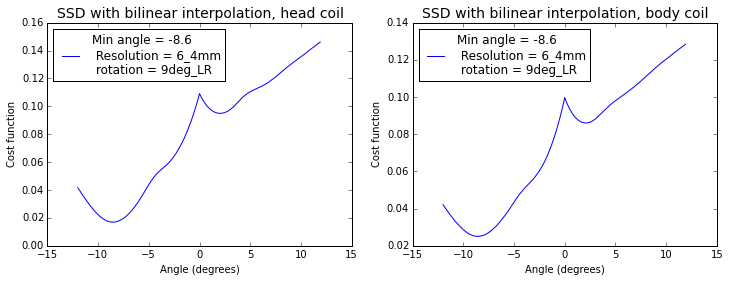

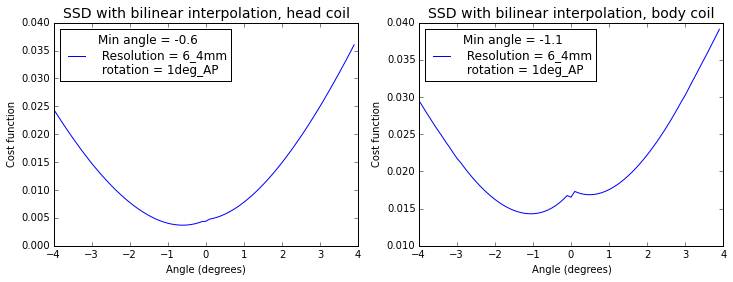

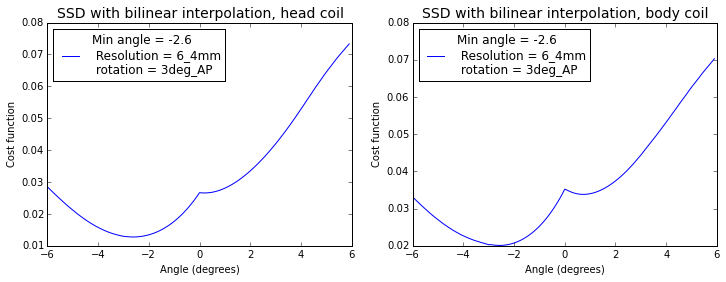

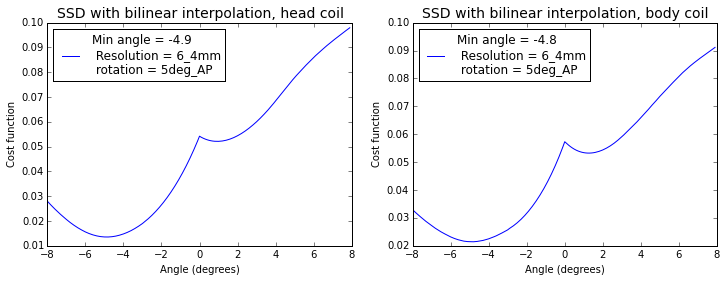

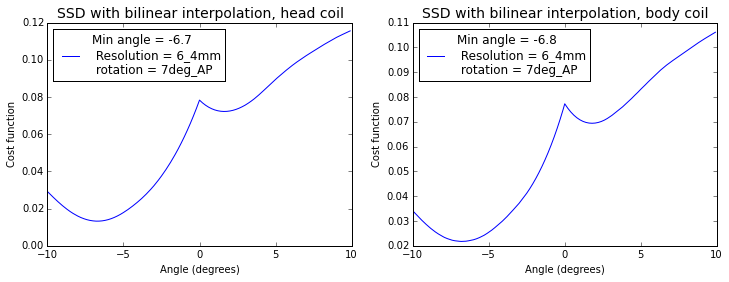

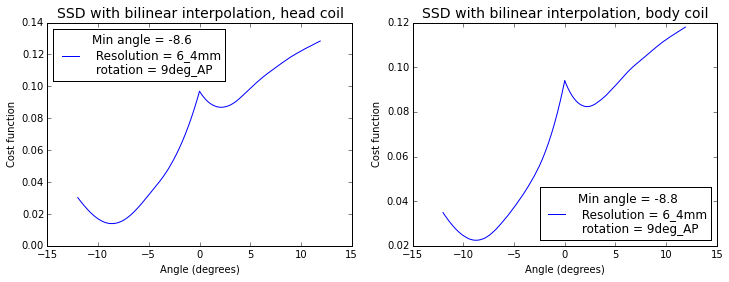

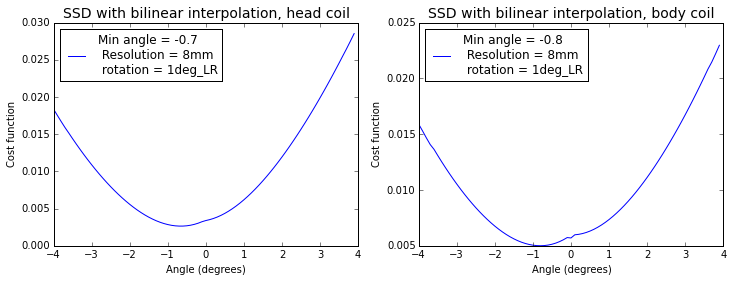

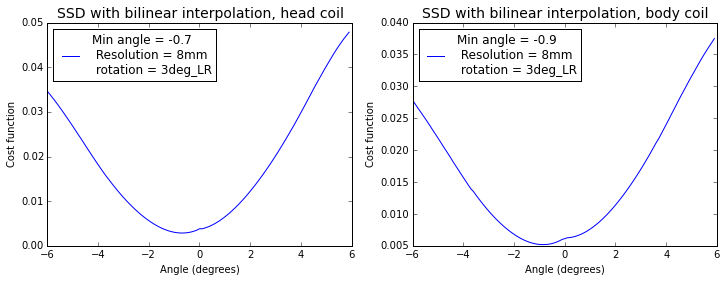

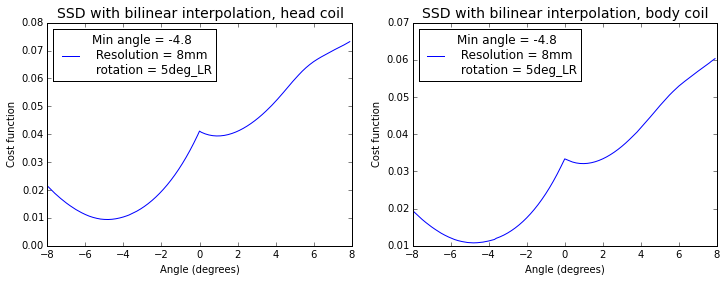

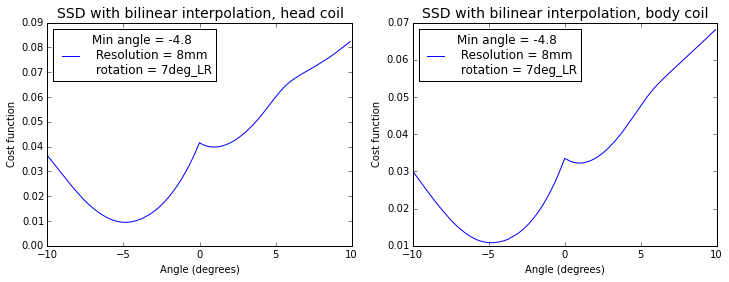

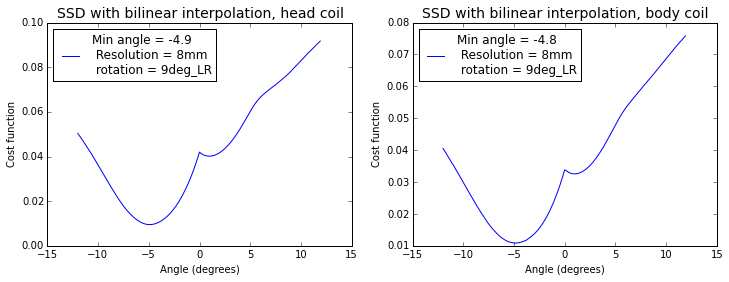

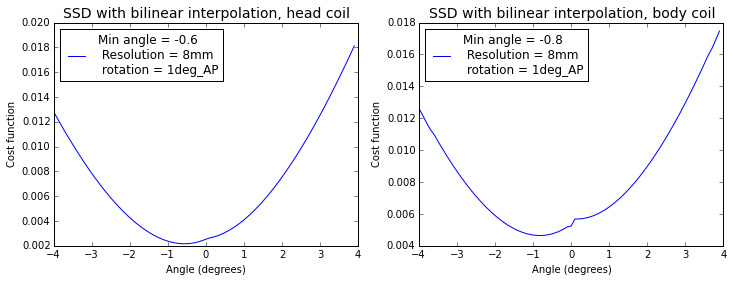

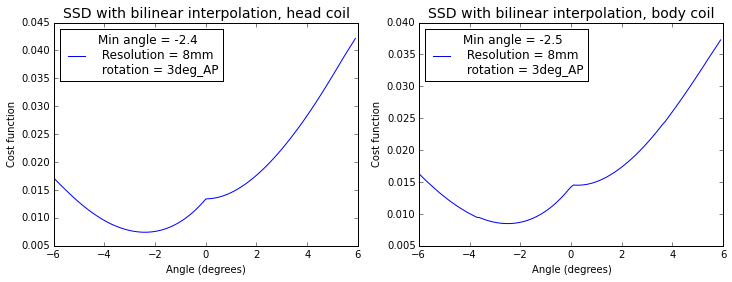

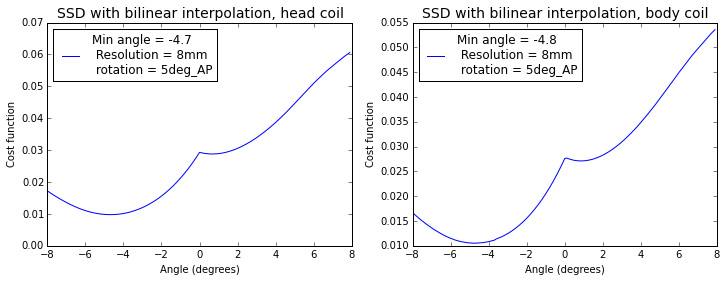

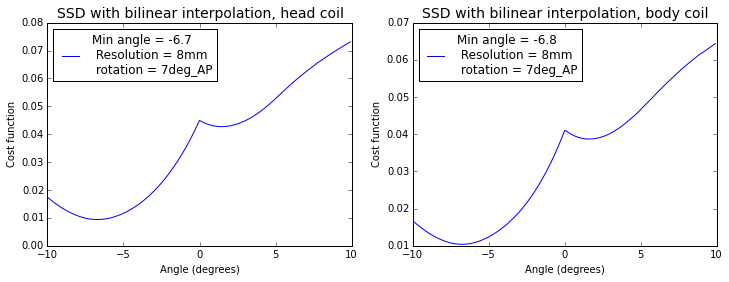

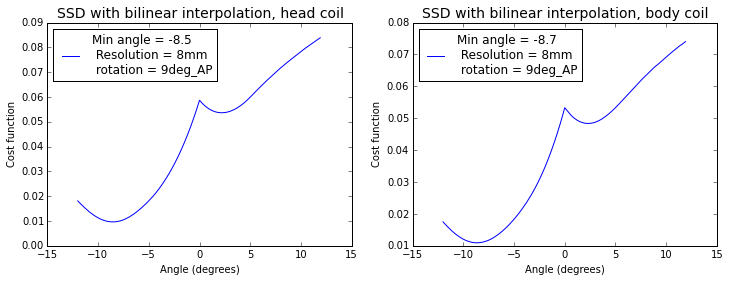

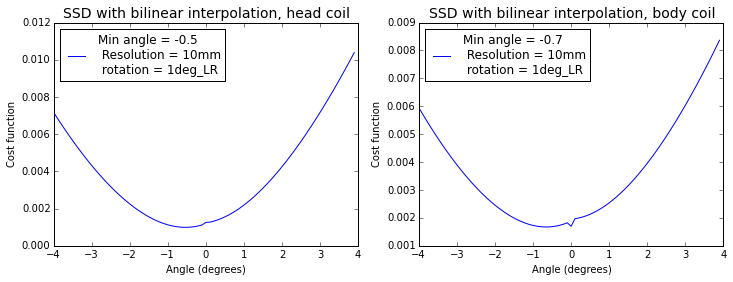

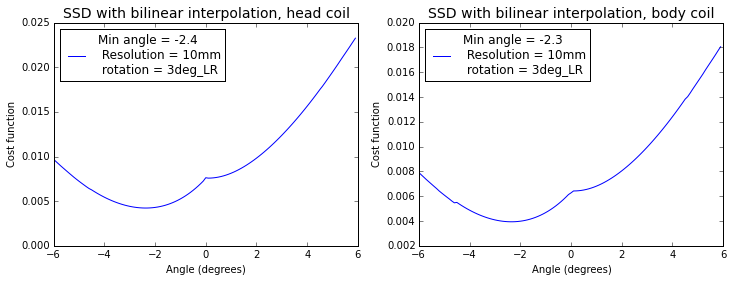

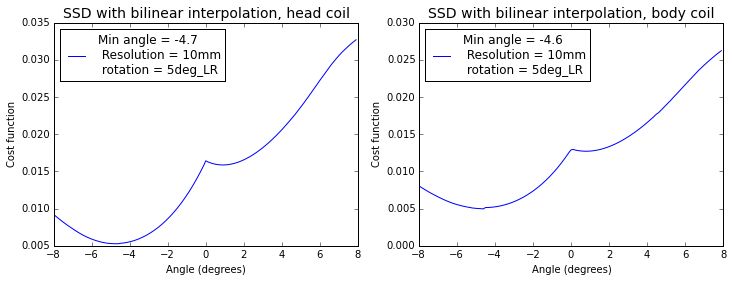

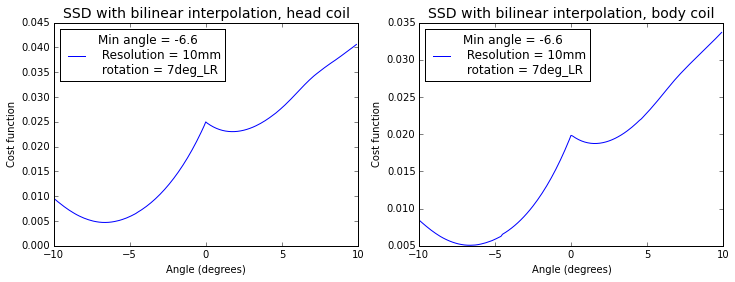

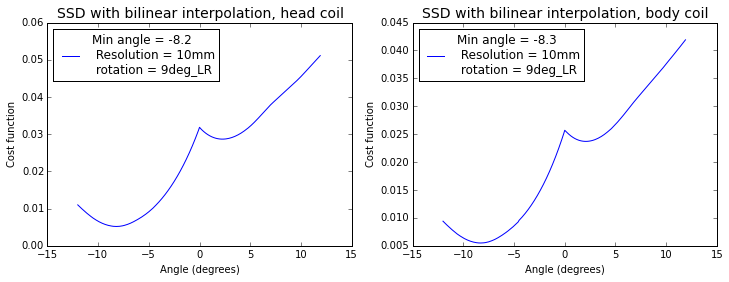

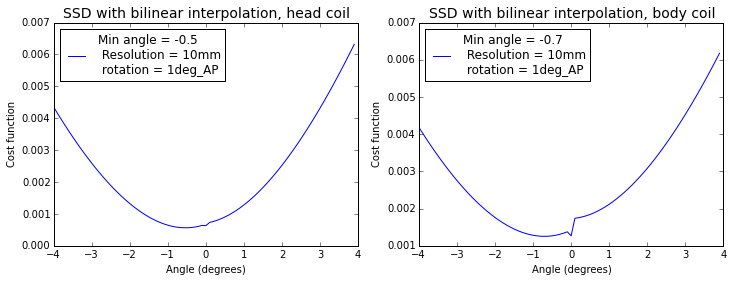

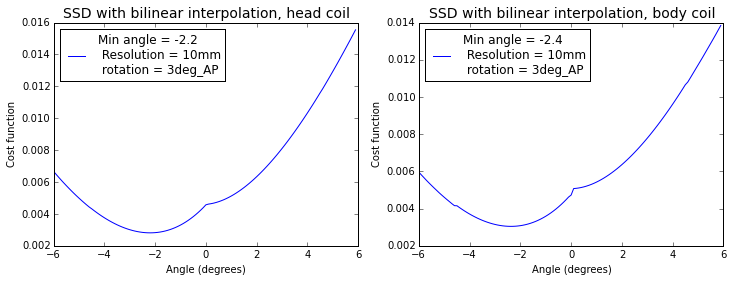

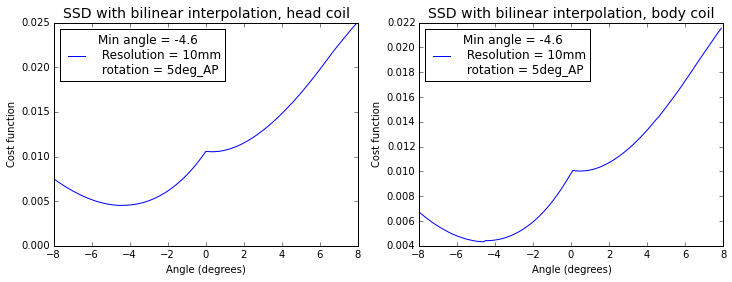

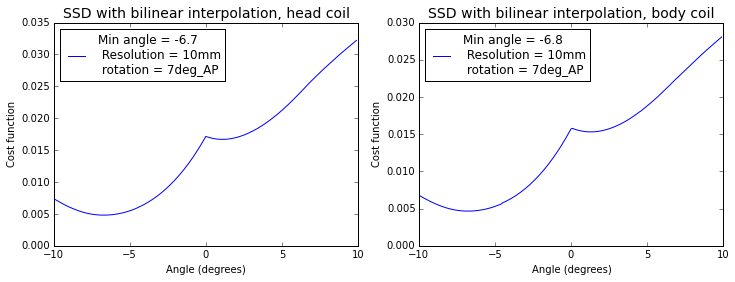

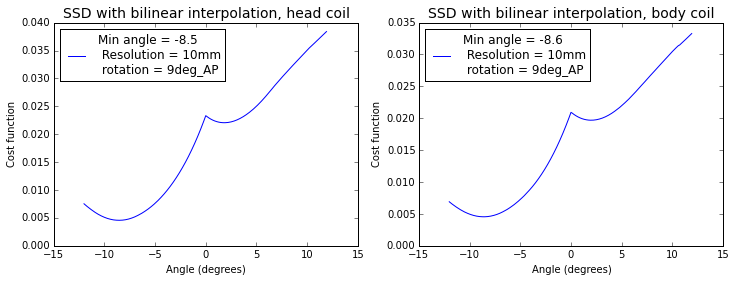

In [56]:
# repetition 1
rot_axes = ['LR','AP']
degrees = ['1deg','3deg','5deg','7deg','9deg']
resolutions = ['5mm','6_4mm','8mm','10mm']
for res in resolutions:
    for rot in rot_axes:
        if(rot == 'LR'): ax = 0
        if(rot == 'AP'): ax = 1
        for deg in degrees:
            plt.figure(figsize=[12,4])
            for idx, coil in enumerate(['head', 'body']):
                d = int(deg[0])
                thetas = np.arange(-d-3,d+3,0.1)
                cost = rot_cost_func(data_dict[res][coil]['iso'][1],data_dict[res][coil][rot][deg][1],thetas,axis=ax)
                plt.subplot(1,2,idx+1)
                plot_cost_func(thetas, cost, res, 'bilinear',deg+'_'+rot, coil)
            plt.show()

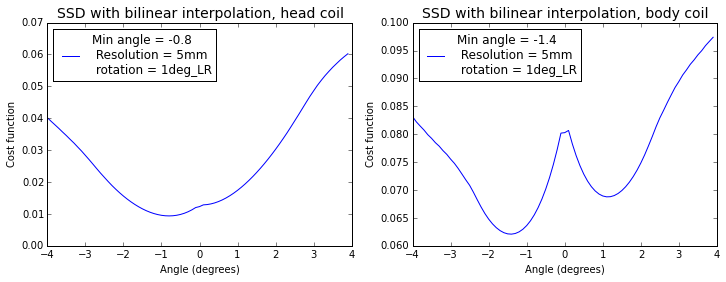

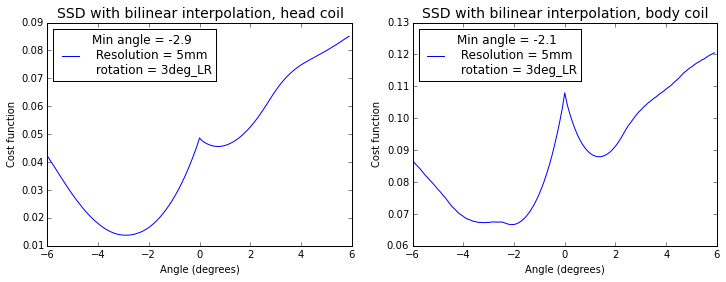

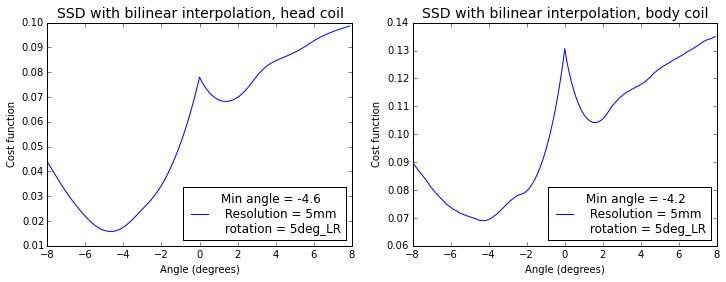

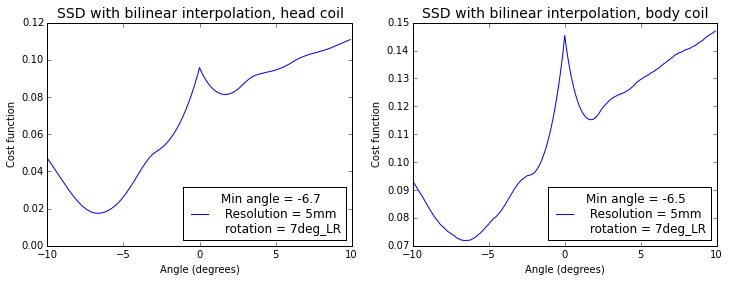

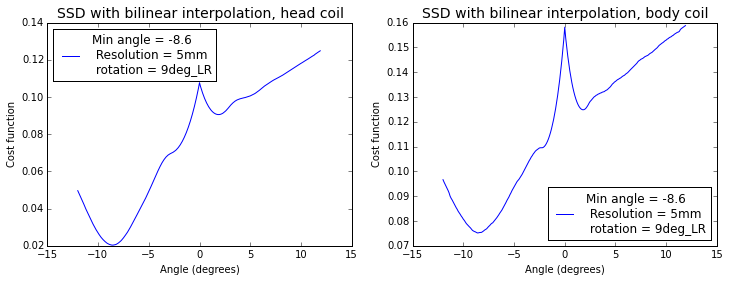

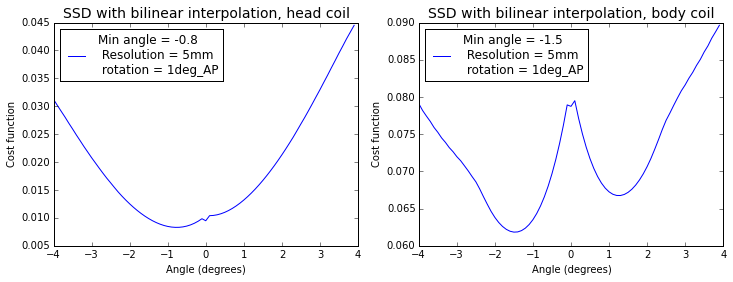

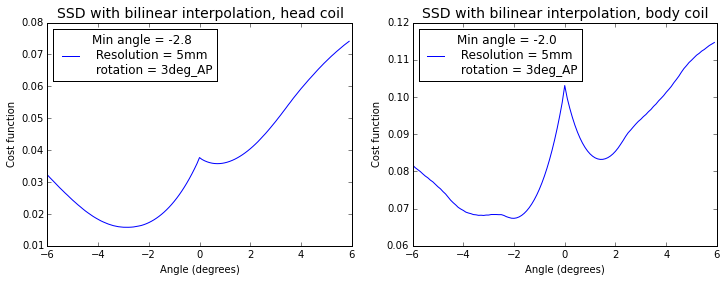

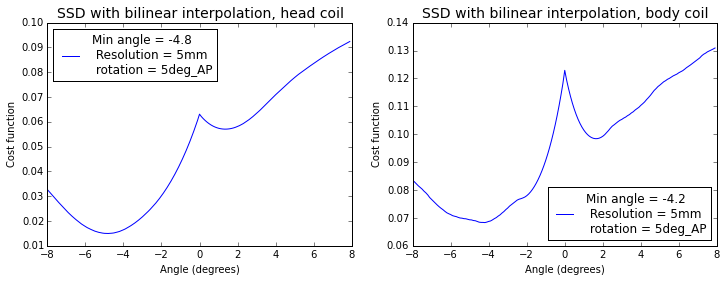

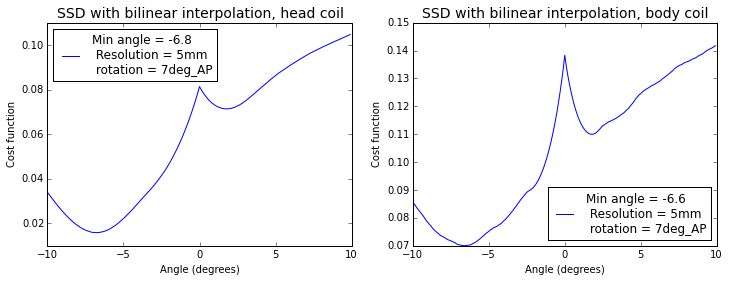

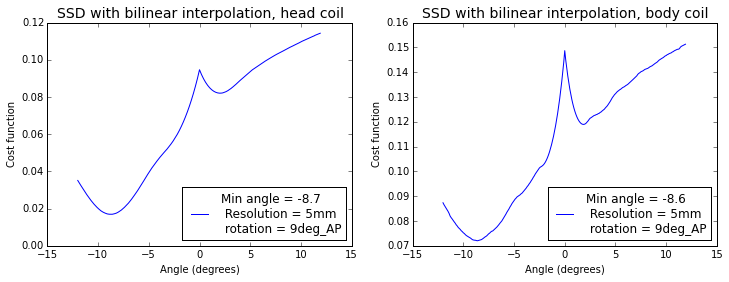

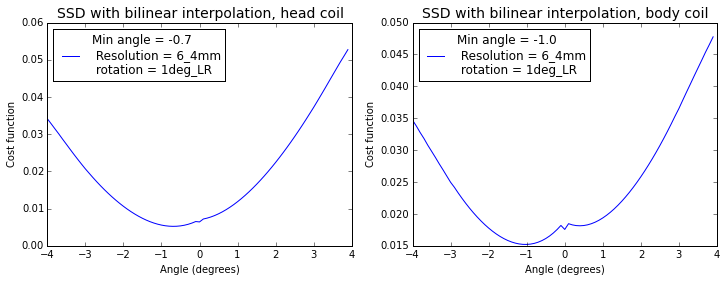

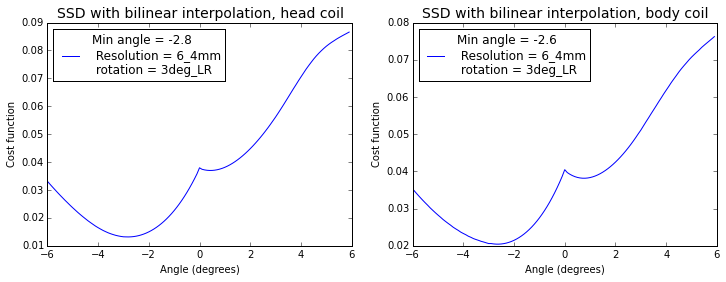

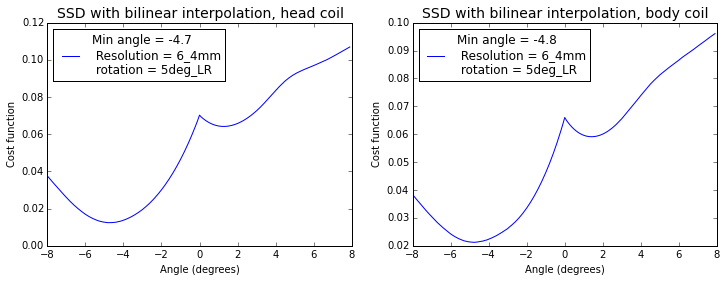

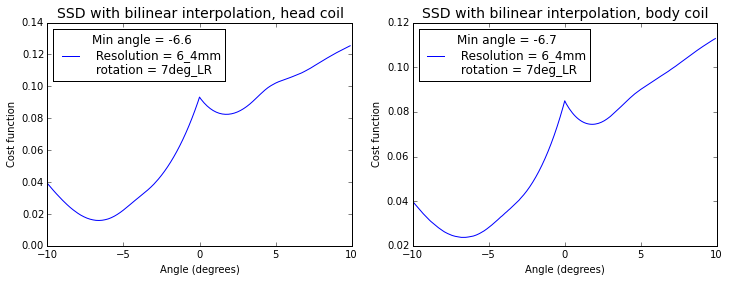

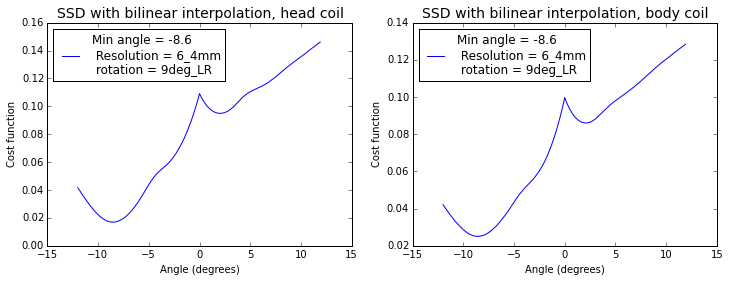

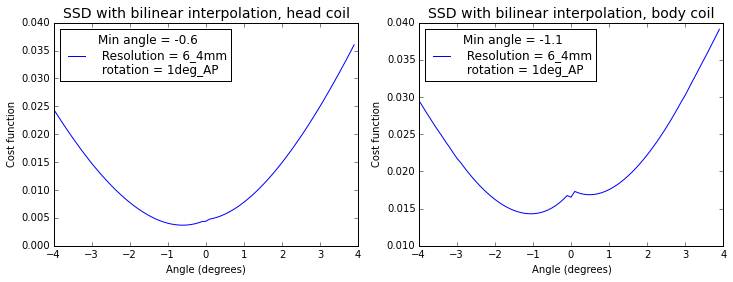

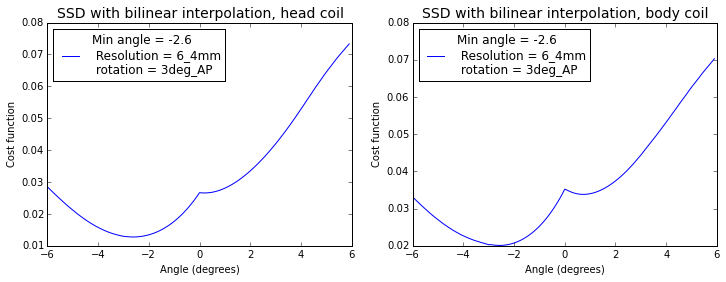

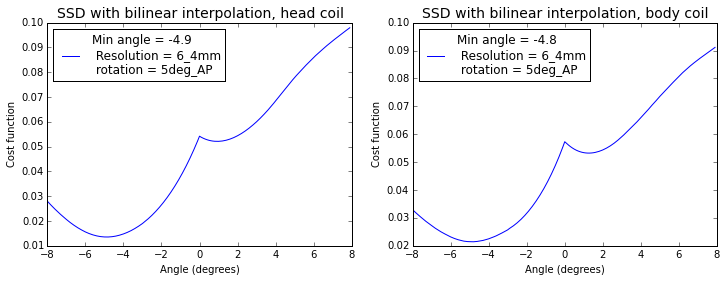

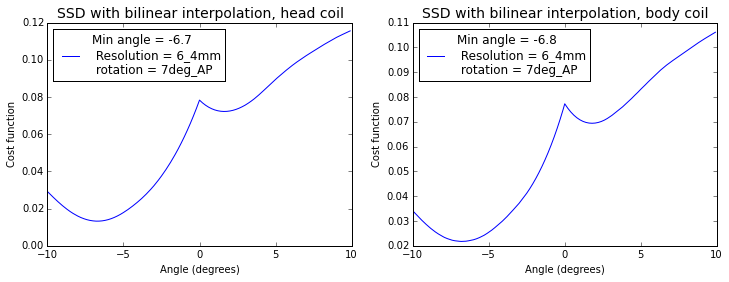

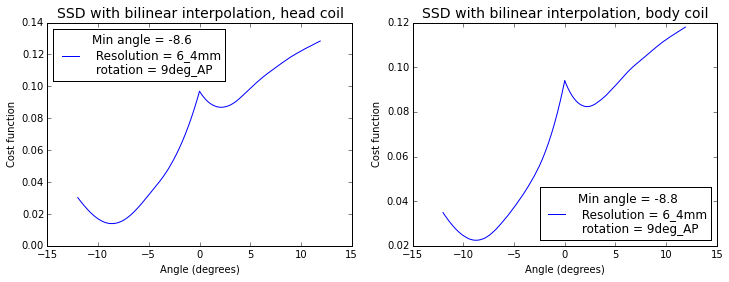

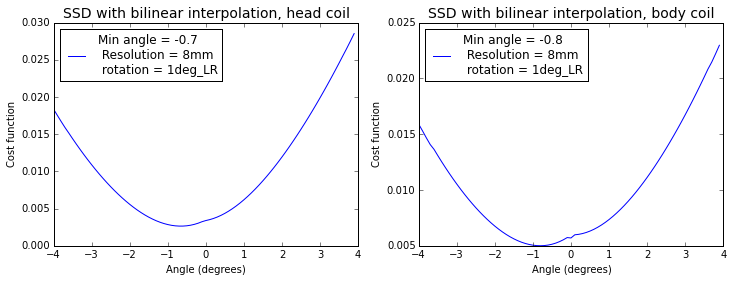

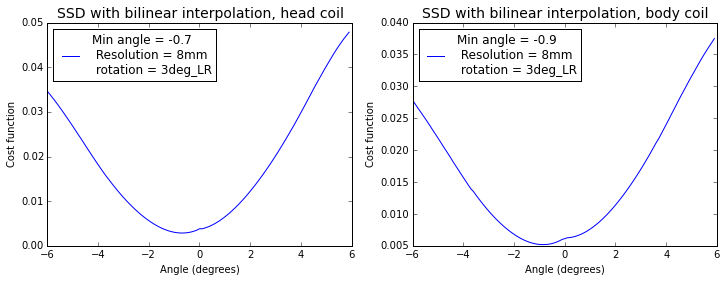

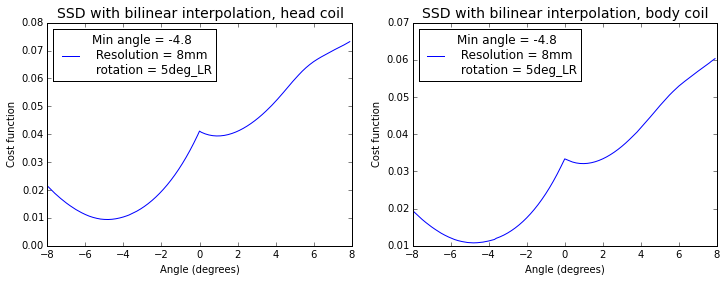

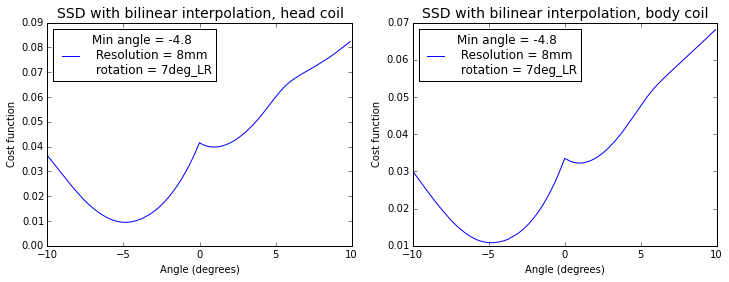

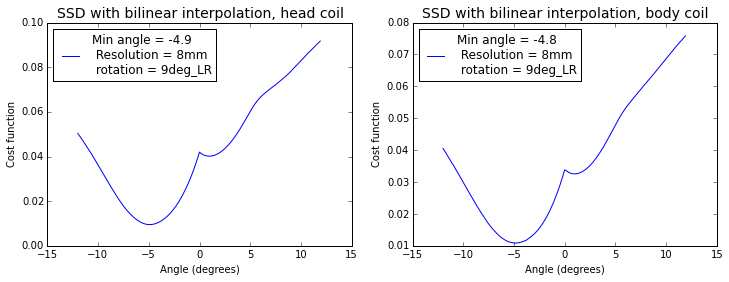

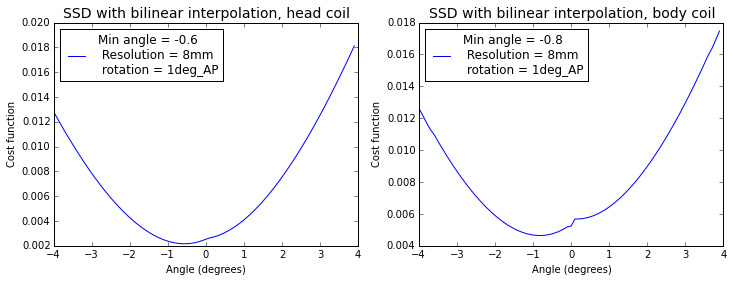

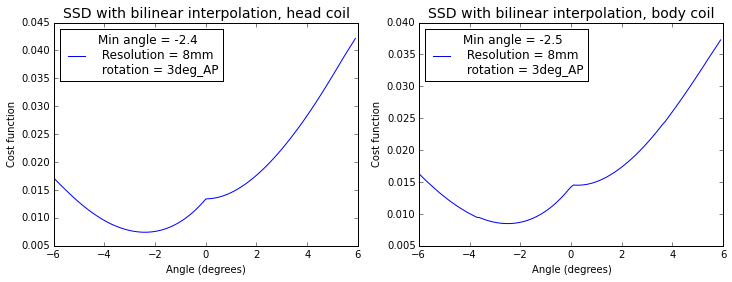

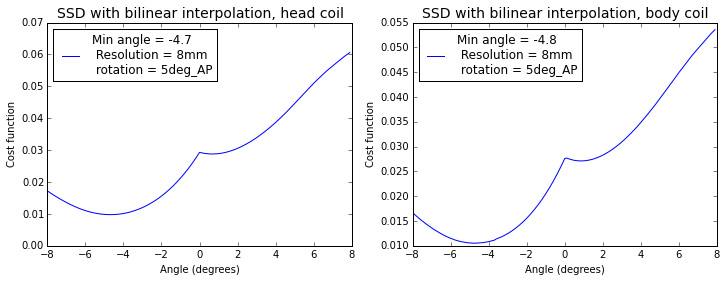

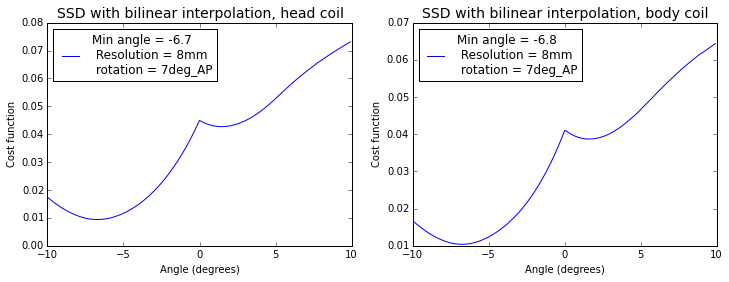

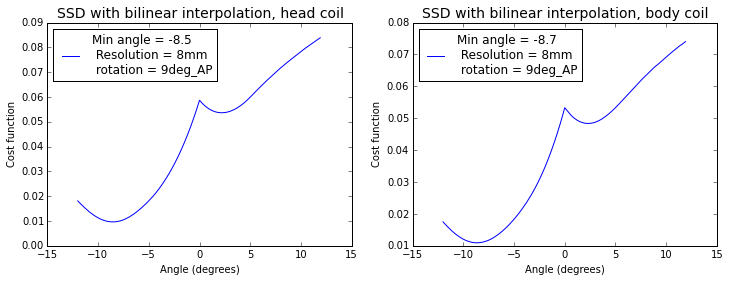

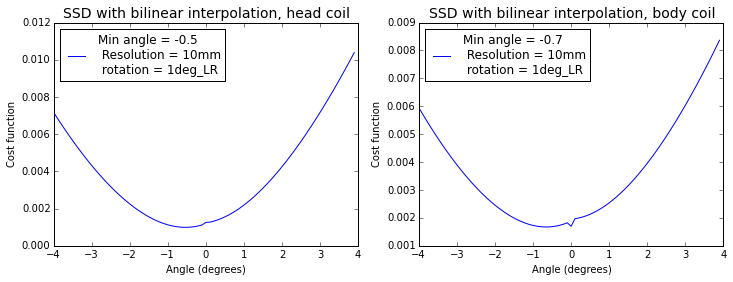

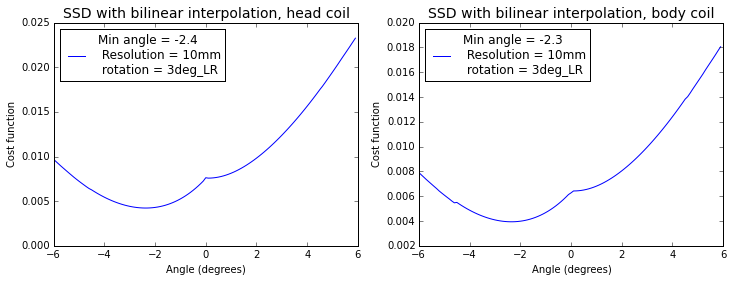

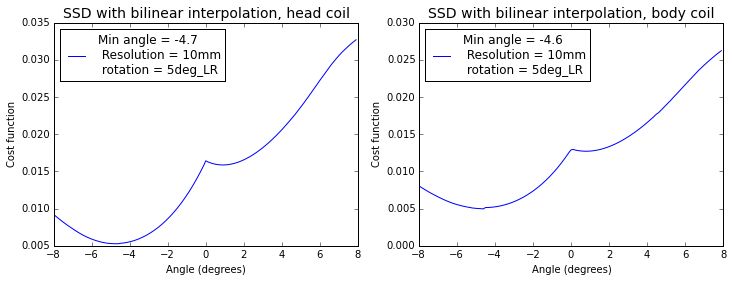

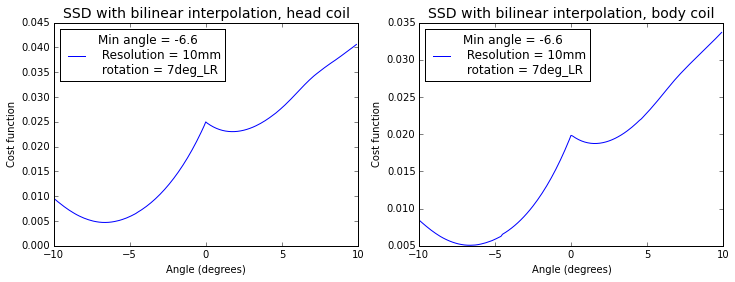

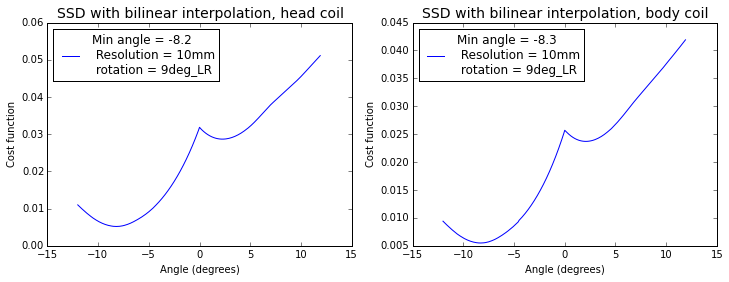

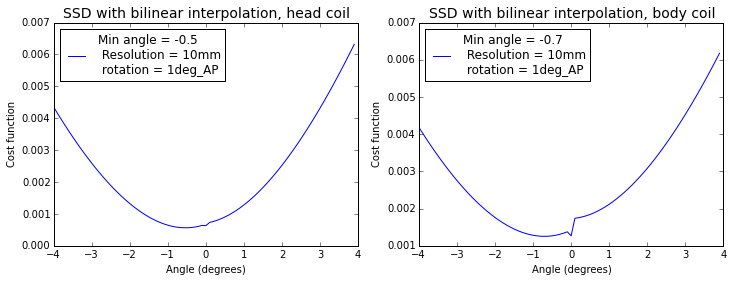

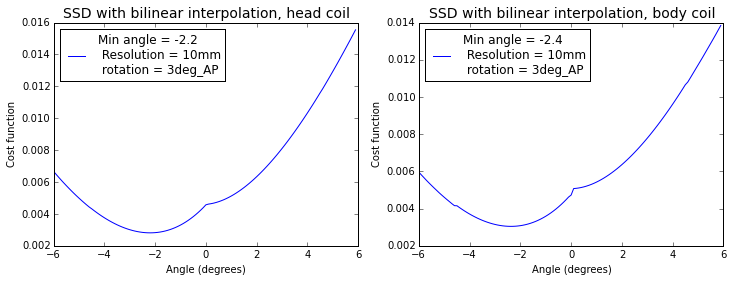

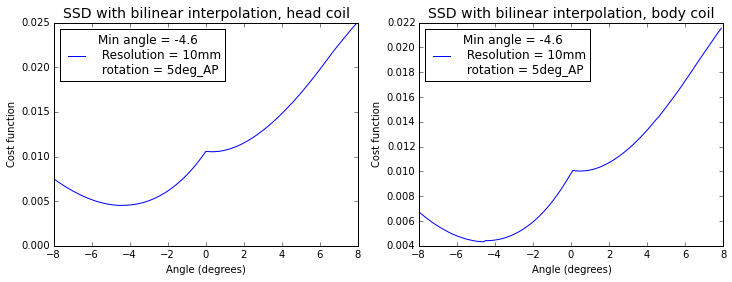

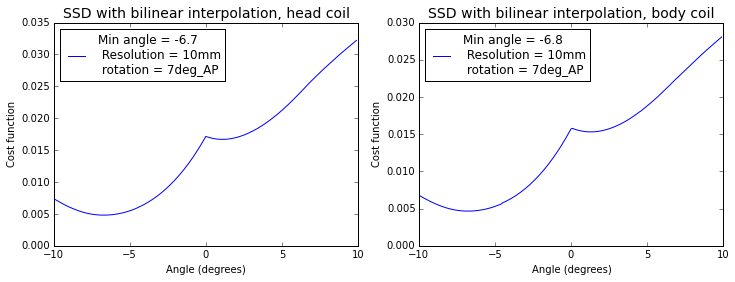

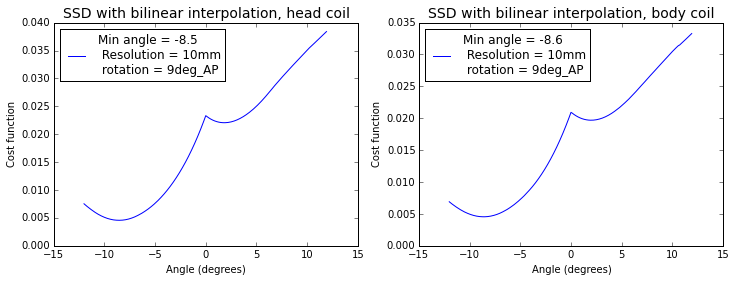

In [57]:
# repetition 2
rot_axes = ['LR','AP']
degrees = ['1deg','3deg','5deg','7deg','9deg']
resolutions = ['5mm','6_4mm','8mm','10mm']
for res in resolutions:
    for rot in rot_axes:
        if(rot == 'LR'): ax = 0
        if(rot == 'AP'): ax = 1
        for deg in degrees:
            plt.figure(figsize=[12,4])
            for idx, coil in enumerate(['head', 'body']):
                d = int(deg[0])
                thetas = np.arange(-d-3,d+3,0.1)
                cost = rot_cost_func(data_dict[res][coil]['iso'][2],data_dict[res][coil][rot][deg][2],thetas,axis=ax)
                plt.subplot(1,2,idx+1)
                plot_cost_func(thetas, cost, res, 'bilinear',deg+'_'+rot, coil)
            plt.show()

5mm head LR 1deg 3deg
5mm body LR 1deg 3deg


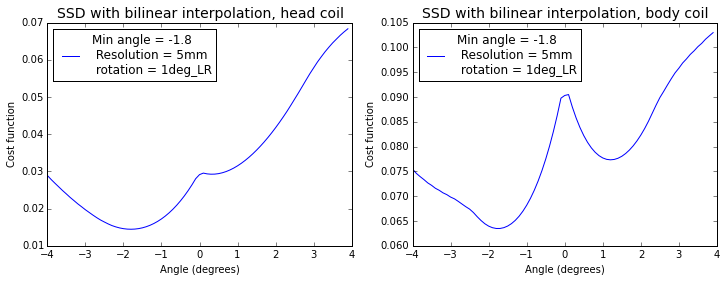

5mm head LR 3deg 5deg
5mm body LR 3deg 5deg


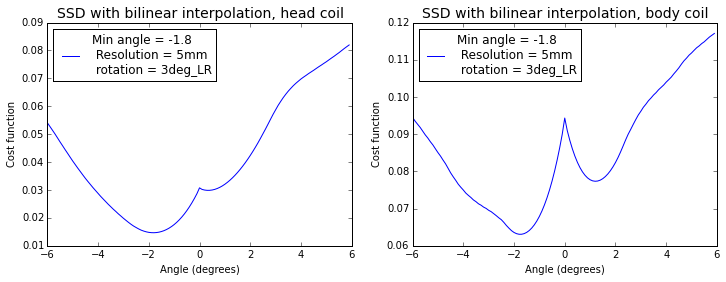

5mm head LR 5deg 7deg
5mm body LR 5deg 7deg


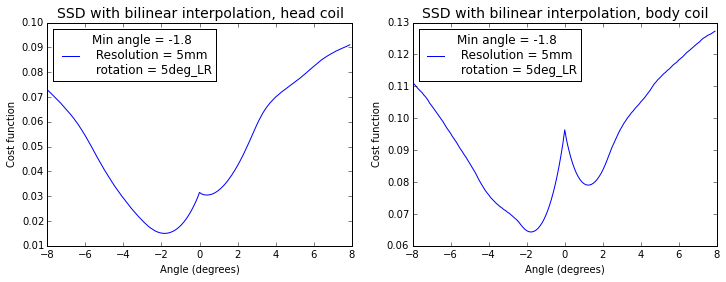

5mm head LR 7deg 9deg
5mm body LR 7deg 9deg


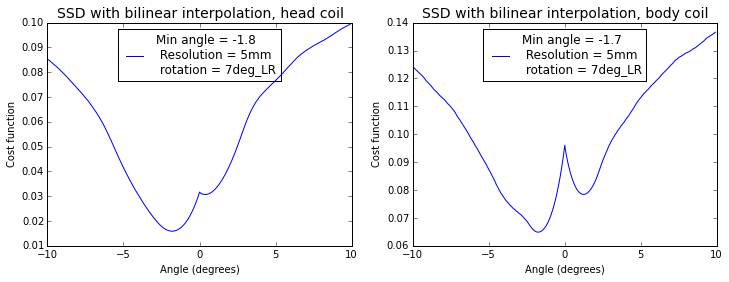

5mm head AP 1deg 3deg
5mm body AP 1deg 3deg


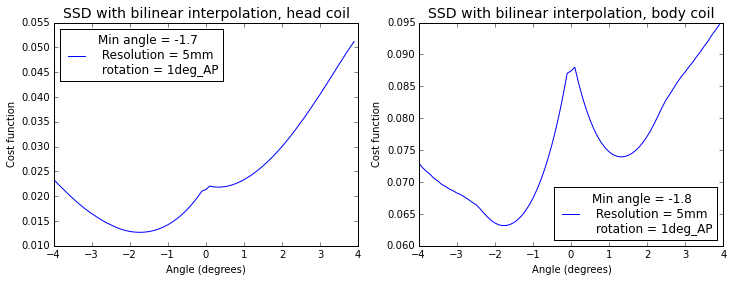

5mm head AP 3deg 5deg
5mm body AP 3deg 5deg


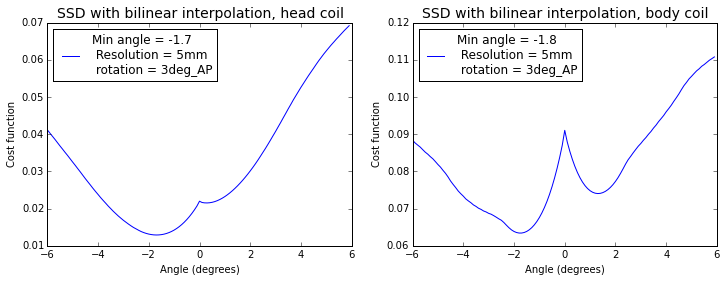

5mm head AP 5deg 7deg
5mm body AP 5deg 7deg


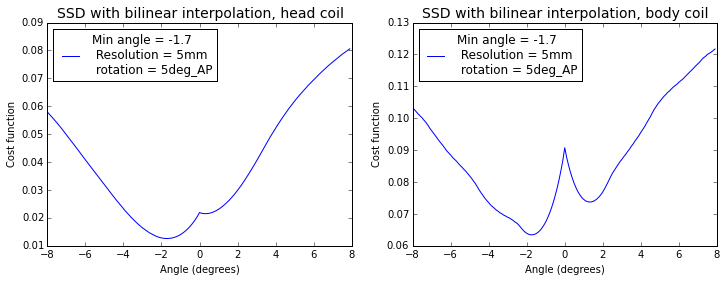

5mm head AP 7deg 9deg
5mm body AP 7deg 9deg


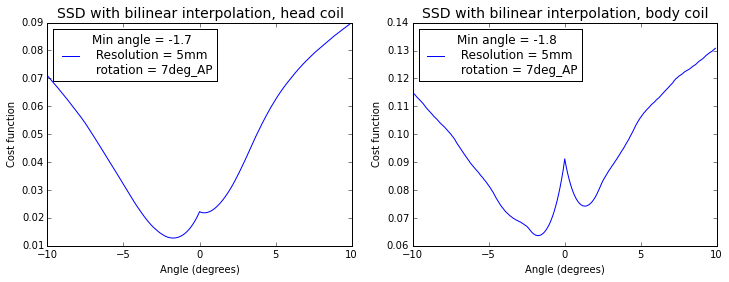

6_4mm head LR 1deg 3deg
6_4mm body LR 1deg 3deg


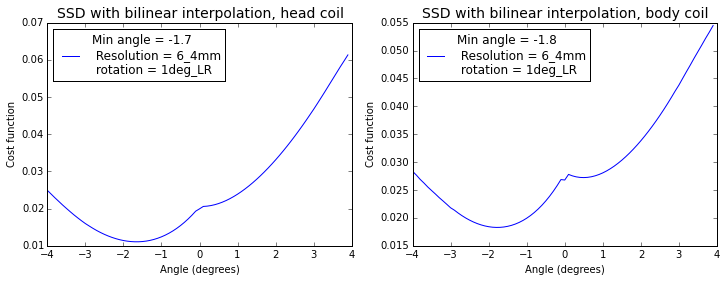

6_4mm head LR 3deg 5deg
6_4mm body LR 3deg 5deg


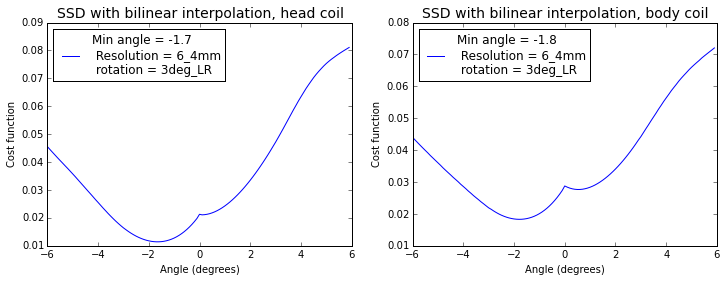

6_4mm head LR 5deg 7deg
6_4mm body LR 5deg 7deg


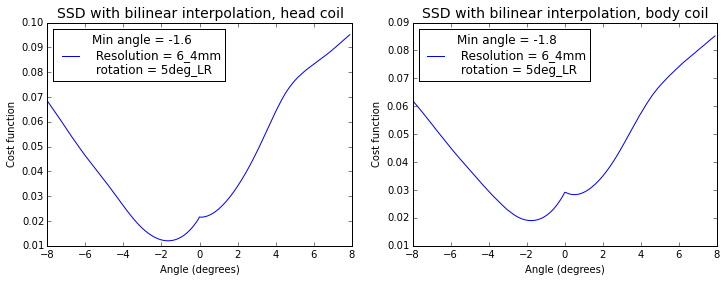

6_4mm head LR 7deg 9deg
6_4mm body LR 7deg 9deg


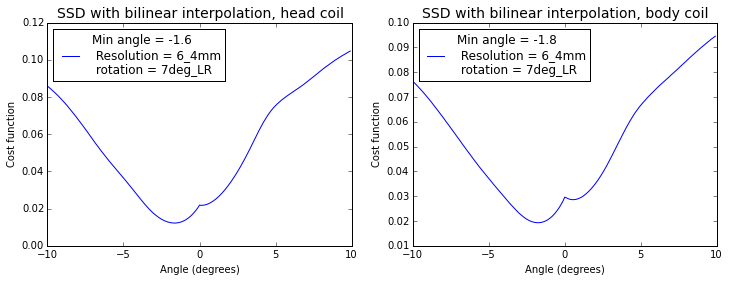

6_4mm head AP 1deg 3deg
6_4mm body AP 1deg 3deg


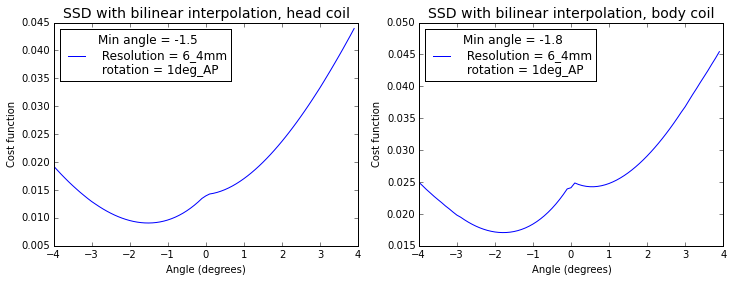

6_4mm head AP 3deg 5deg
6_4mm body AP 3deg 5deg


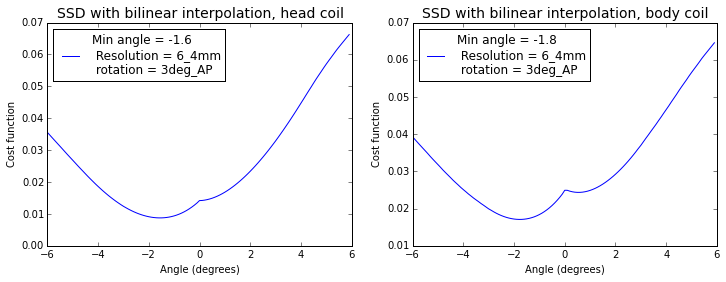

6_4mm head AP 5deg 7deg
6_4mm body AP 5deg 7deg


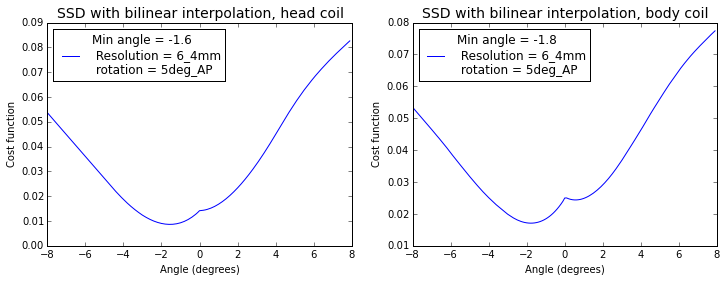

6_4mm head AP 7deg 9deg
6_4mm body AP 7deg 9deg


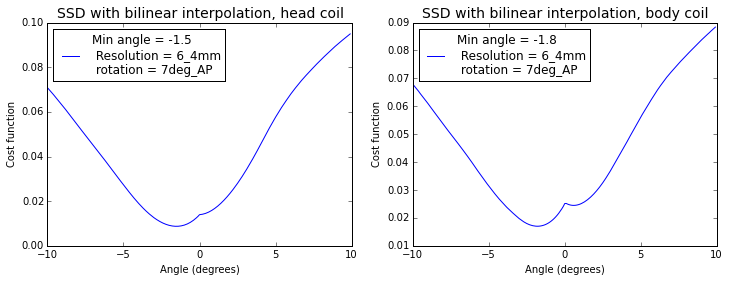

8mm head LR 1deg 3deg
8mm body LR 1deg 3deg


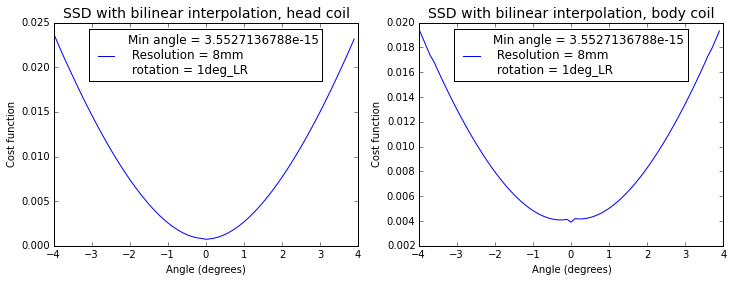

8mm head LR 3deg 5deg
8mm body LR 3deg 5deg


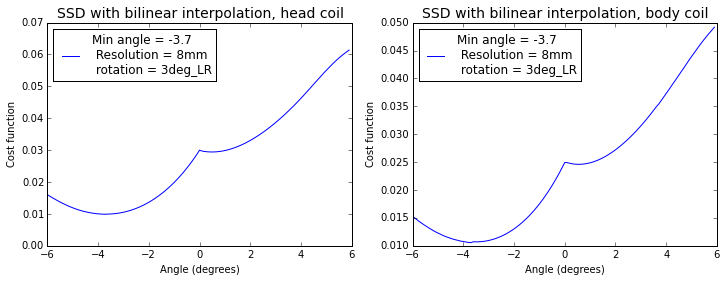

8mm head LR 5deg 7deg
8mm body LR 5deg 7deg


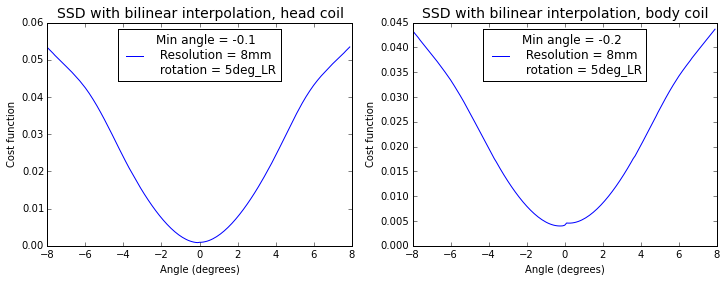

8mm head LR 7deg 9deg
8mm body LR 7deg 9deg


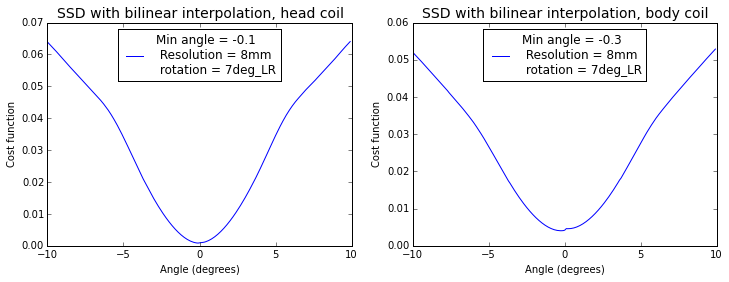

8mm head AP 1deg 3deg
8mm body AP 1deg 3deg


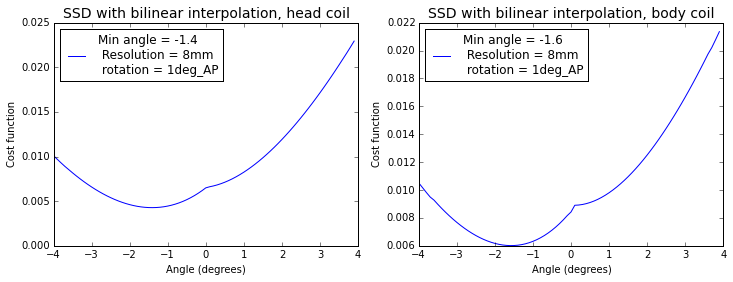

8mm head AP 3deg 5deg
8mm body AP 3deg 5deg


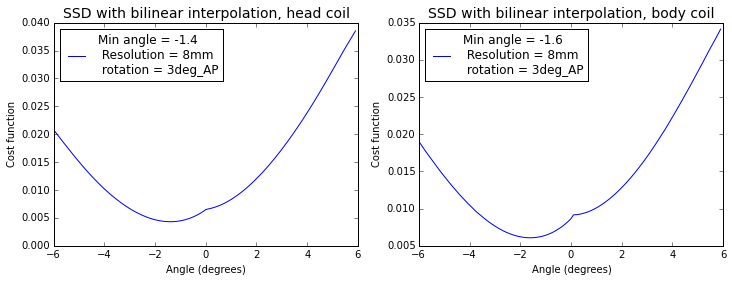

8mm head AP 5deg 7deg
8mm body AP 5deg 7deg


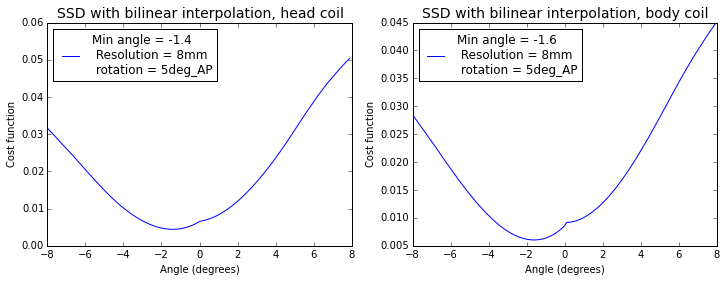

8mm head AP 7deg 9deg
8mm body AP 7deg 9deg


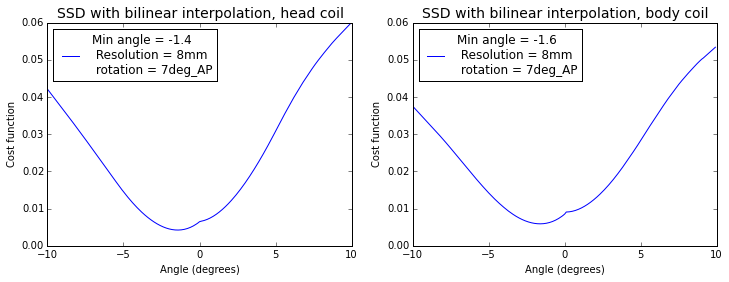

10mm head LR 1deg 3deg
10mm body LR 1deg 3deg


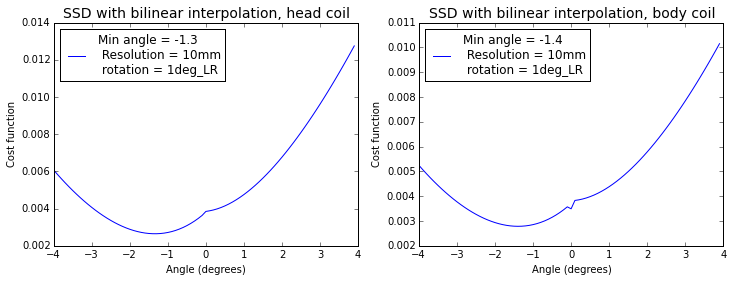

10mm head LR 3deg 5deg
10mm body LR 3deg 5deg


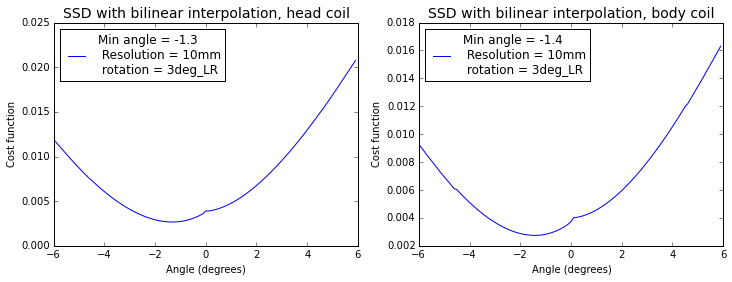

10mm head LR 5deg 7deg
10mm body LR 5deg 7deg


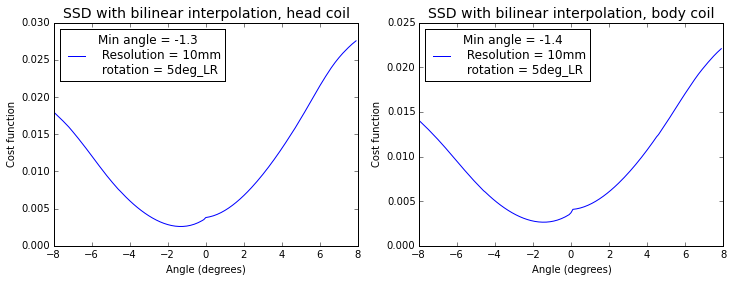

10mm head LR 7deg 9deg
10mm body LR 7deg 9deg


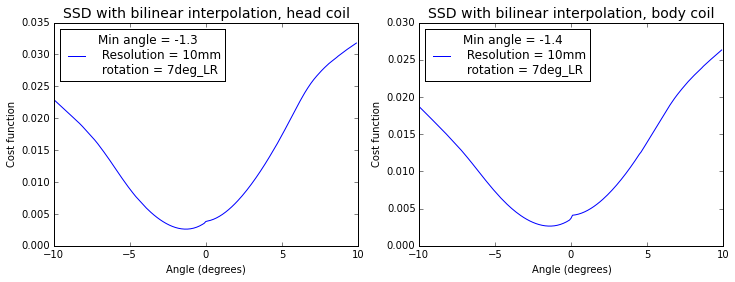

10mm head AP 1deg 3deg
10mm body AP 1deg 3deg


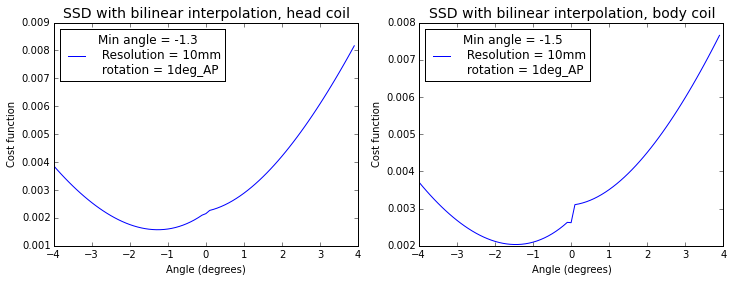

10mm head AP 3deg 5deg
10mm body AP 3deg 5deg


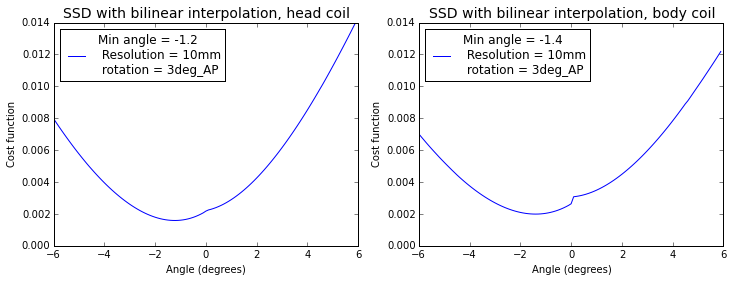

10mm head AP 5deg 7deg
10mm body AP 5deg 7deg


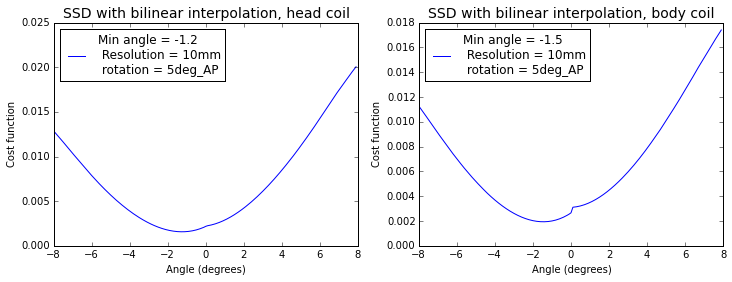

10mm head AP 7deg 9deg
10mm body AP 7deg 9deg


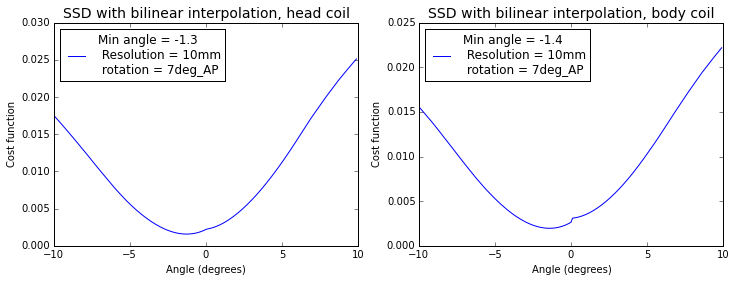

In [78]:
# cross registering
rot_axes = ['LR','AP']
degrees = ['1deg','3deg','5deg','7deg','9deg']
resolutions = ['5mm','6_4mm','8mm','10mm']
for res in resolutions:
    for rot in rot_axes:
        if(rot == 'LR'): ax = 0
        if(rot == 'AP'): ax = 1
        for idx_deg, deg in enumerate(degrees[:-1]):
            plt.figure(figsize=[12,4])
            for idx, coil in enumerate(['head', 'body']):
                d = int(deg[0])
                thetas = np.arange(-d-3,d+3,0.1)
                print res,coil,rot,deg,degrees[idx_deg+1]
                cost = rot_cost_func(data_dict[res][coil][rot][deg][0],data_dict[res][coil][rot][degrees[idx_deg+1]][0],thetas,axis=ax)
                plt.subplot(1,2,idx+1)
                plot_cost_func(thetas, cost, res, 'bilinear',deg+'_'+rot, coil)
            plt.show()

5mm head LR 3deg 1deg
5mm body LR 3deg 1deg


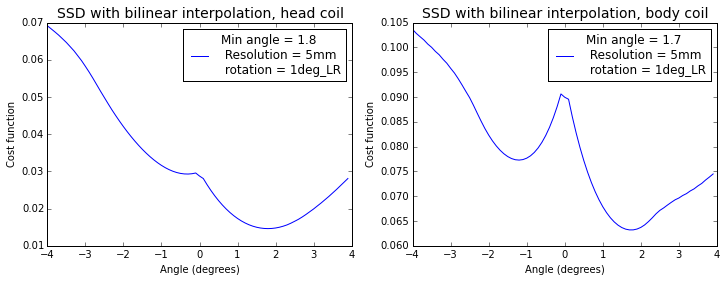

5mm head LR 5deg 3deg
5mm body LR 5deg 3deg


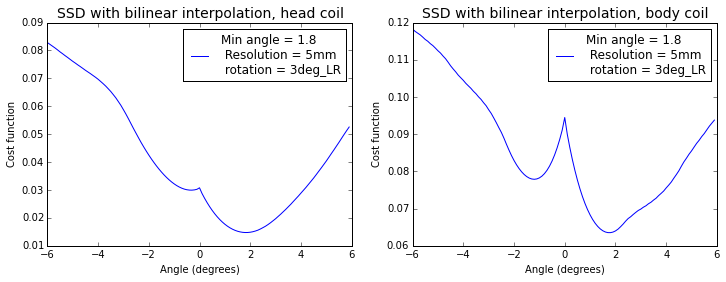

5mm head LR 7deg 5deg
5mm body LR 7deg 5deg


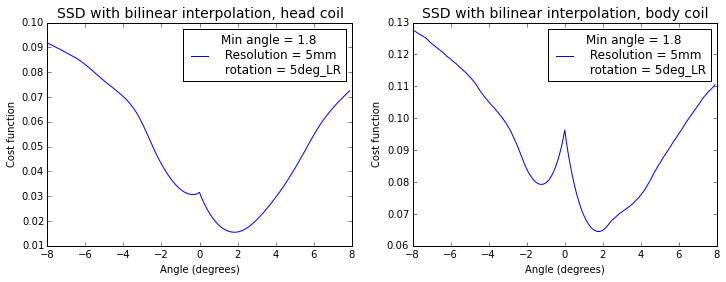

5mm head LR 9deg 7deg
5mm body LR 9deg 7deg


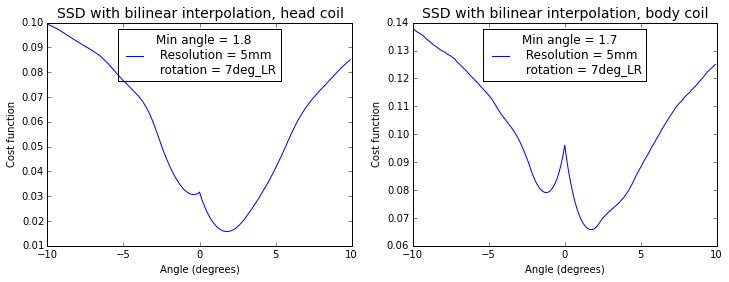

5mm head AP 3deg 1deg
5mm body AP 3deg 1deg


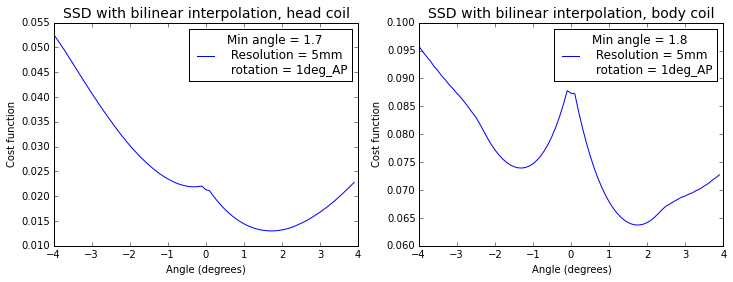

5mm head AP 5deg 3deg
5mm body AP 5deg 3deg


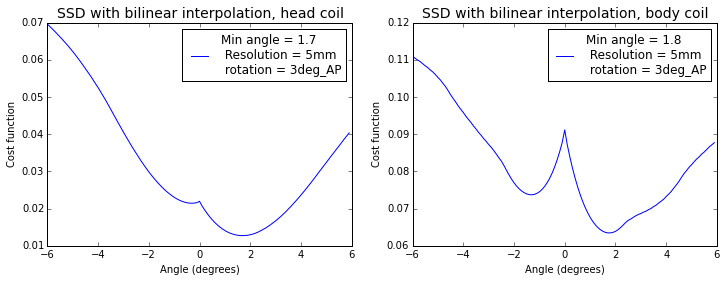

5mm head AP 7deg 5deg
5mm body AP 7deg 5deg


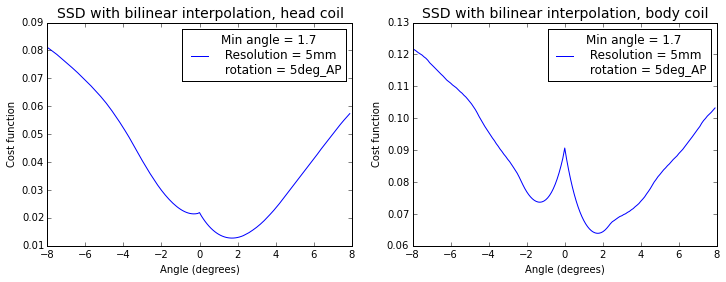

5mm head AP 9deg 7deg
5mm body AP 9deg 7deg


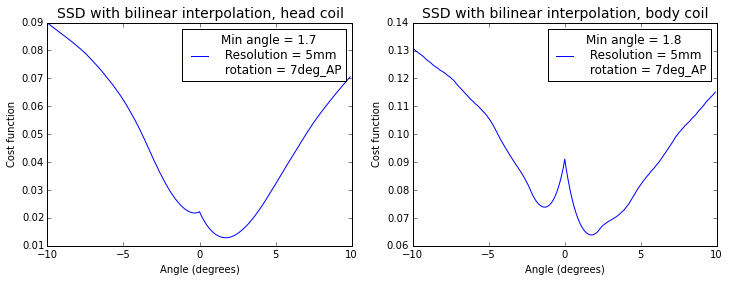

6_4mm head LR 3deg 1deg
6_4mm body LR 3deg 1deg


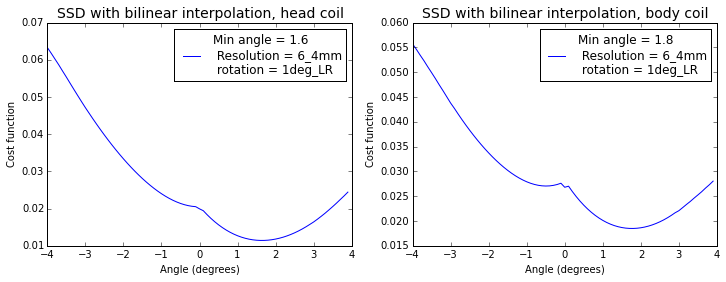

6_4mm head LR 5deg 3deg
6_4mm body LR 5deg 3deg


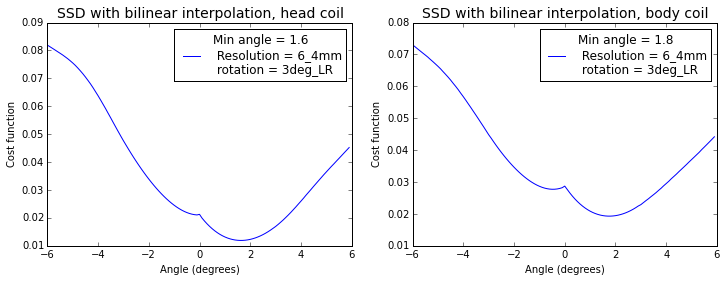

6_4mm head LR 7deg 5deg
6_4mm body LR 7deg 5deg


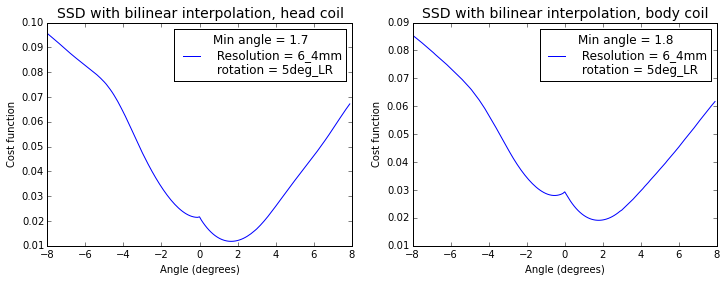

6_4mm head LR 9deg 7deg
6_4mm body LR 9deg 7deg


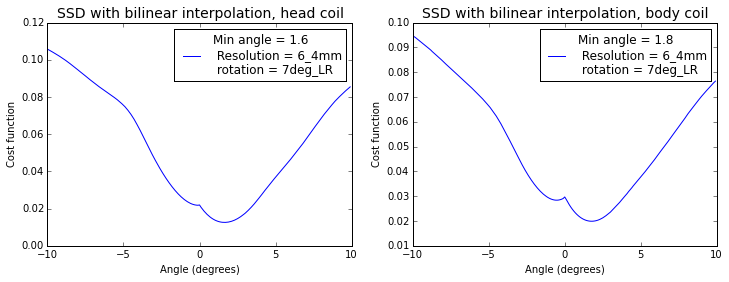

6_4mm head AP 3deg 1deg
6_4mm body AP 3deg 1deg


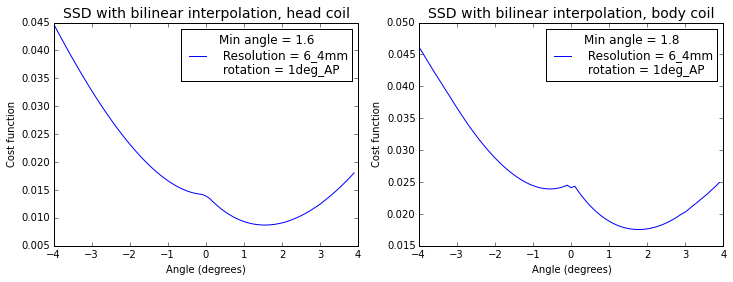

6_4mm head AP 5deg 3deg
6_4mm body AP 5deg 3deg


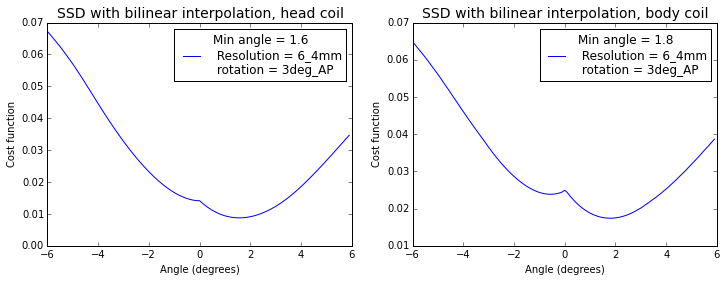

6_4mm head AP 7deg 5deg
6_4mm body AP 7deg 5deg


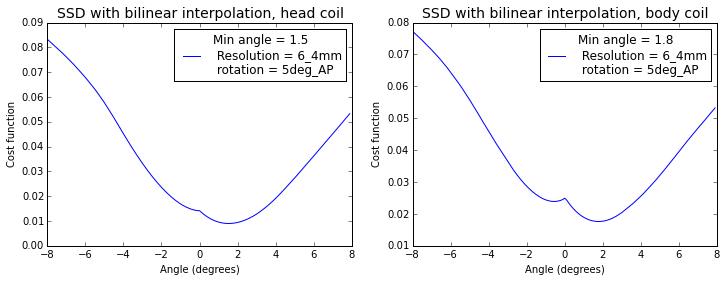

6_4mm head AP 9deg 7deg
6_4mm body AP 9deg 7deg


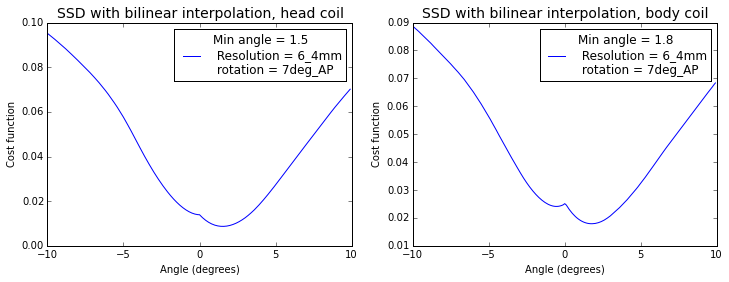

8mm head LR 3deg 1deg
8mm body LR 3deg 1deg


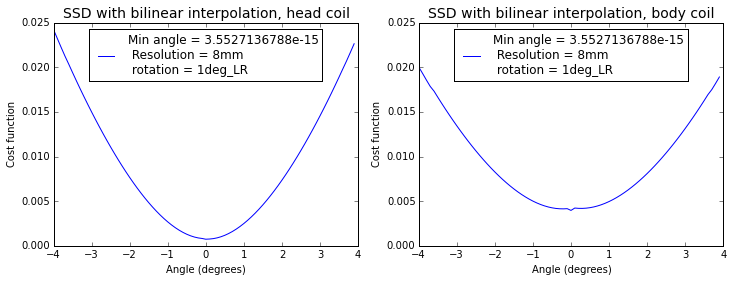

8mm head LR 5deg 3deg
8mm body LR 5deg 3deg


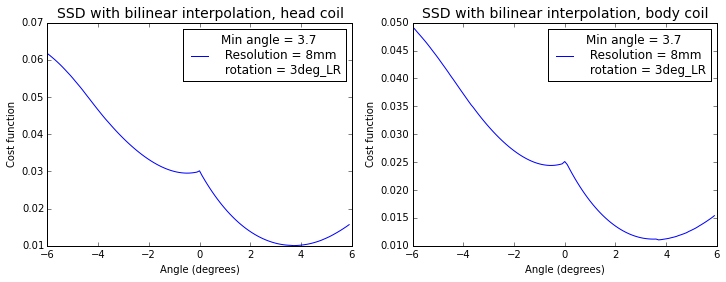

8mm head LR 7deg 5deg
8mm body LR 7deg 5deg


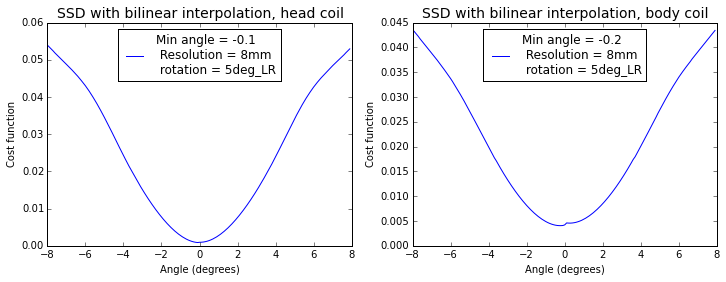

8mm head LR 9deg 7deg
8mm body LR 9deg 7deg


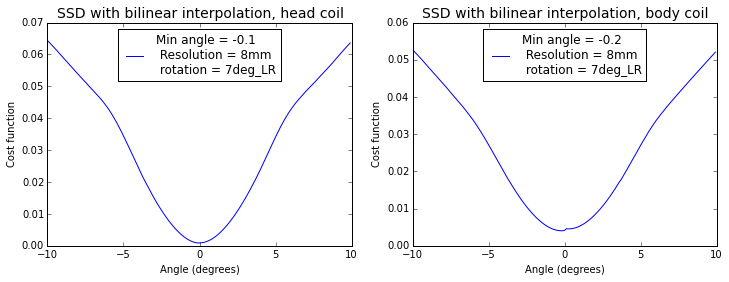

8mm head AP 3deg 1deg
8mm body AP 3deg 1deg


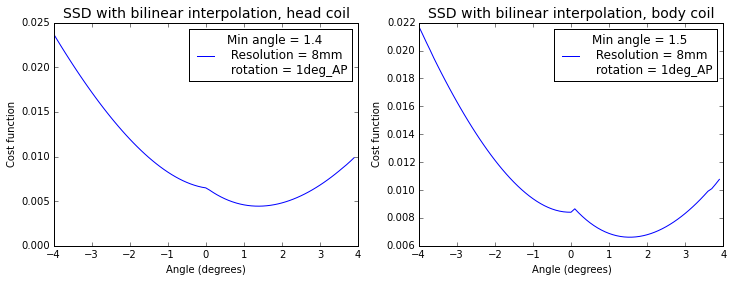

8mm head AP 5deg 3deg
8mm body AP 5deg 3deg


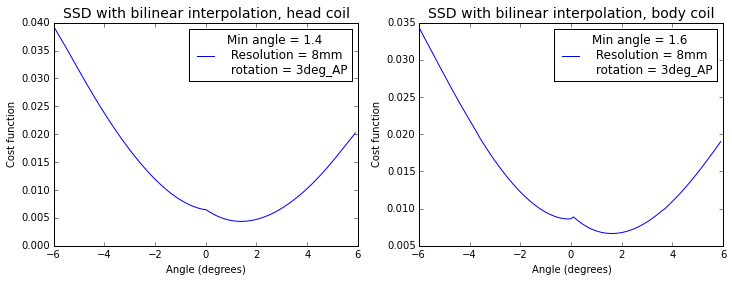

8mm head AP 7deg 5deg
8mm body AP 7deg 5deg


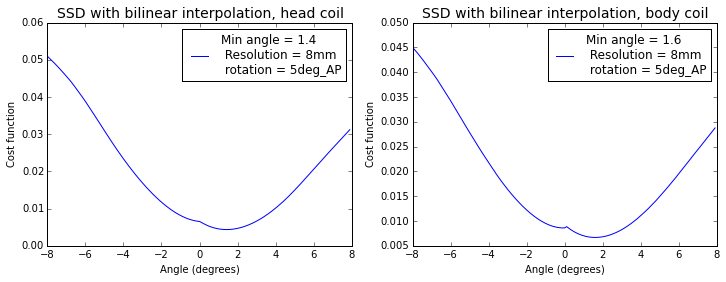

8mm head AP 9deg 7deg
8mm body AP 9deg 7deg


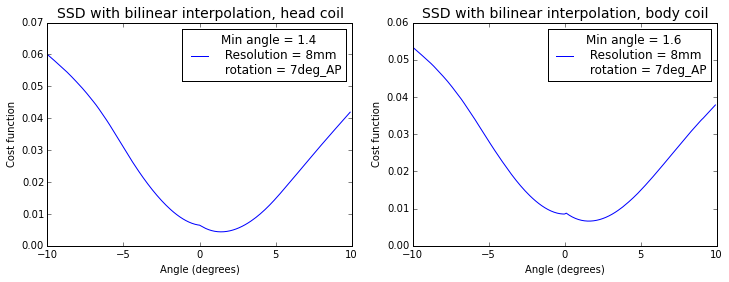

10mm head LR 3deg 1deg
10mm body LR 3deg 1deg


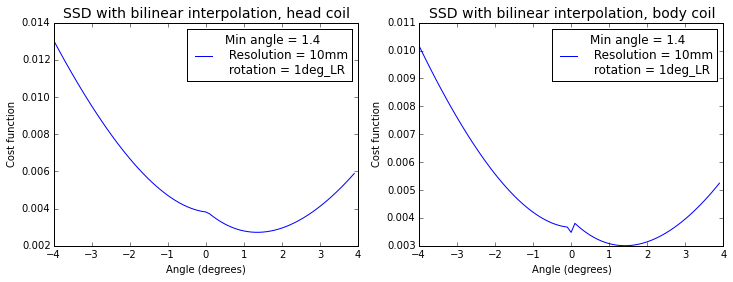

10mm head LR 5deg 3deg
10mm body LR 5deg 3deg


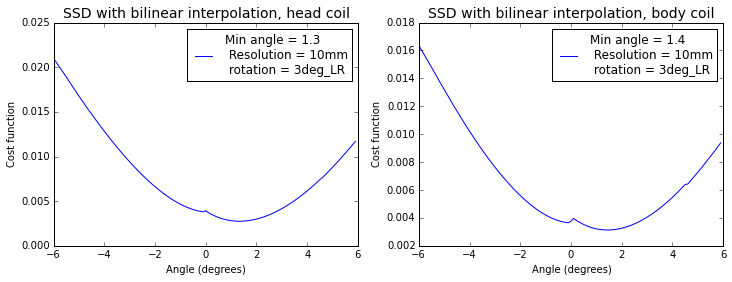

10mm head LR 7deg 5deg
10mm body LR 7deg 5deg


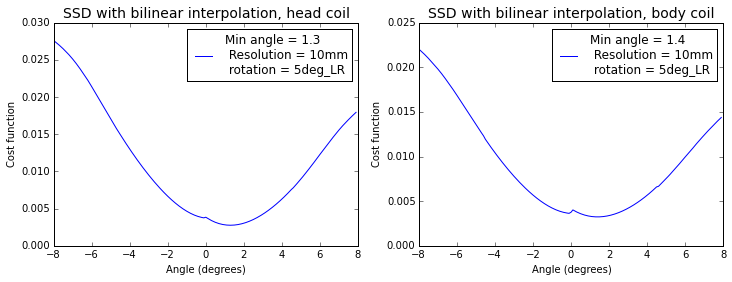

10mm head LR 9deg 7deg
10mm body LR 9deg 7deg


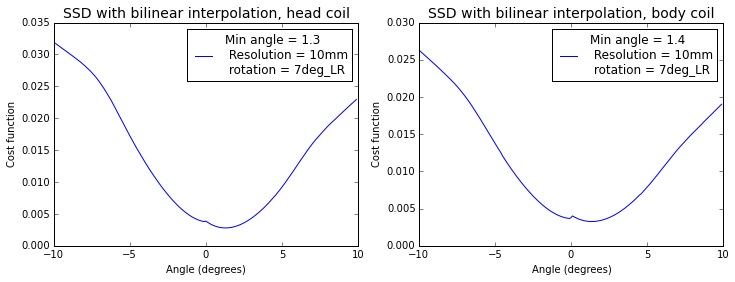

10mm head AP 3deg 1deg
10mm body AP 3deg 1deg


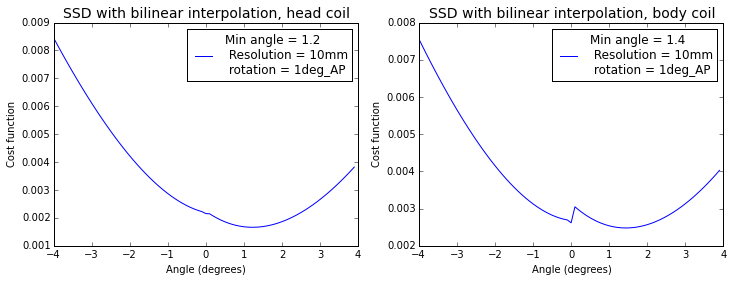

10mm head AP 5deg 3deg
10mm body AP 5deg 3deg


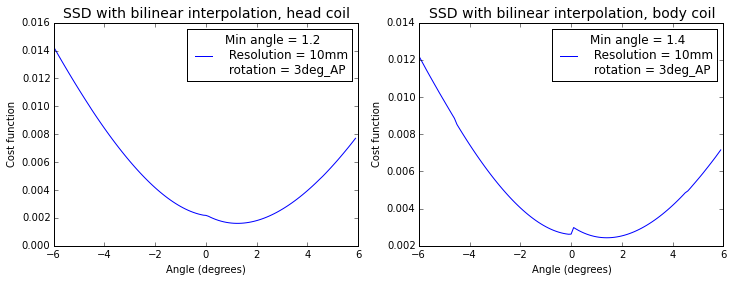

10mm head AP 7deg 5deg
10mm body AP 7deg 5deg


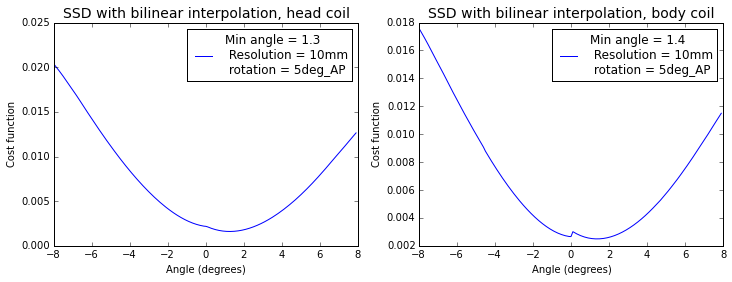

10mm head AP 9deg 7deg
10mm body AP 9deg 7deg


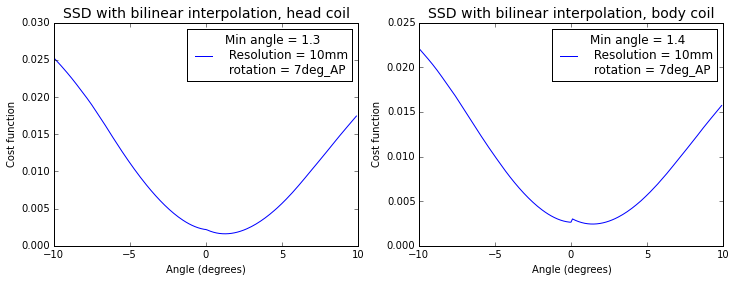

In [79]:
# cross registering revered
rot_axes = ['LR','AP']
degrees = ['1deg','3deg','5deg','7deg','9deg']
resolutions = ['5mm','6_4mm','8mm','10mm']
for res in resolutions:
    for rot in rot_axes:
        if(rot == 'LR'): ax = 0
        if(rot == 'AP'): ax = 1
        for idx_deg, deg in enumerate(degrees[:-1]):
            plt.figure(figsize=[12,4])
            for idx, coil in enumerate(['head', 'body']):
                d = int(deg[0])
                thetas = np.arange(-d-3,d+3,0.1)
                print res,coil,rot,degrees[idx_deg+1],deg
                cost = rot_cost_func(data_dict[res][coil][rot][degrees[idx_deg+1]][0],data_dict[res][coil][rot][deg][0],thetas,axis=ax)
                plt.subplot(1,2,idx+1)
                plot_cost_func(thetas, cost, res, 'bilinear',deg+'_'+rot, coil)
            plt.show()